# Notebook ejemplo para el reto HidroPredictiva.

### En este notebook mostraremos un ejemplo de como entrenar y hacer el submission de kaggle. **Este notebook no tiene como objetivo hacer el mejor modelo sino mostrar un ejemplo de cómo trabajar con datos meteorológicos para hacer uno.**





### También, enseñaremos como hacer la medición del consumo eléctrico usando codecarbon.

En la primera celda instalamos la librería *codecarbon*, inicializamos el emission tracker y empezamos la medición.

In [1]:
# !pip install codecarbon --quiet

    # Para instalarlo me funcionó con "conda install -c conda-forge codecarbon"

from codecarbon import EmissionsTracker

tracker = EmissionsTracker()

tracker.start()

[codecarbon INFO @ 03:26:12] [setup] RAM Tracking...

[codecarbon INFO @ 03:26:12] [setup] GPU Tracking...

[codecarbon INFO @ 03:26:12] Tracking Nvidia GPU via pynvml

[codecarbon INFO @ 03:26:12] [setup] CPU Tracking...

[codecarbon WARNING @ 03:26:12] No CPU tracking mode found. Falling back on CPU constant mode. 

 Windows OS detected: Please install Intel Power Gadget to measure CPU



[codecarbon INFO @ 03:26:13] CPU Model on constant consumption mode: AMD Ryzen 5 5600X 6-Core Processor

[codecarbon INFO @ 03:26:13] >>> Tracker's metadata:

[codecarbon INFO @ 03:26:13]   Platform system: Windows-10-10.0.22631-SP0

[codecarbon INFO @ 03:26:13]   Python version: 3.9.18

[codecarbon INFO @ 03:26:13]   CodeCarbon version: 2.7.1

[codecarbon INFO @ 03:26:13]   Available RAM : 31.900 GB

[codecarbon INFO @ 03:26:13]   CPU count: 12

[codecarbon INFO @ 03:26:13]   CPU model: AMD Ryzen 5 5600X 6-Core Processor

[codecarbon INFO @ 03:26:13]   GPU count: 1

[codecarbon INFO @ 03:26:13]   G

## Empezamos la transformación del DataFrame para el modelado y el **feature engineering**.



En la segunda celda importamos las librerias que necesitaremos.

In [2]:
# from kaggle_secrets import UserSecretsClient

from ast import literal_eval

from sklearn.metrics.pairwise import haversine_distances

from math import radians

import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

from pprint import pprint

from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error

import tensorflow as tf

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense

from tensorflow.keras.layers import LSTM

from tensorflow.keras.layers import Dropout

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import RMSprop

pd.set_option('mode.chained_assignment', None)

Aquí definimos algunas funciones y variables de utilidad. 

- Necesitamos una función que nos permita calcular la distancia entre los emplazamientos y los puntos en los datos del GFS. 

- Necesitamos funciones que nos den un DataFrame en formato *long*, que nos permita modelar el caudal con una observación por dia.

In [3]:
def distance_in_globe(latlon_reference: tuple[float], latlon: tuple[float]):

    """

    Calcula la distancia entre dos puntos en el globo usando su latitud y longitud.

    

    Parametros:

    

    latlon_reference (tuple[float]): Latitud y longitud del punto de referencia.

    latlon (tuple[float]): Latitud y longitud del punto al que mediremos la distancia. 

    

    Returns:

    

    float: Distancia de haversine entre ambos puntos.

    """

    # Convert latitude and longitude from degrees to radians

    ref_radians = [radians(_) for _ in latlon_reference]

    point_radians = [radians(_) for _ in latlon]

    # Calculate the haversine distance between the two points

    return haversine_distances([ref_radians, point_radians])[0, 1]





def prediction_hr_pivot(gfs_df: pd.DataFrame, emplazamiento_name: str):

    """

    Pivot el DataFrame para crear columnas con los horizontes de predicción del GFS. 



    Parametros:

    

    gfs_df (pd.DataFrame): DataFrame que contiene data del GFS.

    emplazamiento_name (str): Nombre del emplazamiento



    Returns:

    

    pd.DataFrame: DataFrame formato wide.

    """

    # Convert valid_time and time columns to datetime

    gfs_df["valid_time"] = pd.to_datetime(gfs_df["valid_time"], format="mixed")

    gfs_df["time"] = pd.to_datetime(gfs_df["time"])

    # Calculate the prediction horizon in hours

    components = (gfs_df["valid_time"] - gfs_df["time"]).dt.components

    gfs_df["prediction_horizon_hr"] = components["days"] * 24 + components["hours"]

    # Drop the valid_time column

    gfs_df.drop("valid_time", axis=1, inplace=True)

    # Pivot the DataFrame

    pivoted = gfs_df.pivot_table(index="time", columns="prediction_horizon_hr")

    pivoted.columns = ["_".join([str(c) for c in grouped_c]) for grouped_c in pivoted.columns.values]

    pivoted["emplazamiento"] = emplazamiento_name

    return pivoted





def modelling_df(gfs_df_dict: pd.DataFrame):

    """

    Combina los DataFrame y añade variables dummy del emplazamiento para que usarse para modelar.



    Parametros:

    

    gfs_df_dict (pd.DataFrame): Diccionario de DataFrames.



    Returns:

    

    pd.DataFrame: DataFrame combinar con dummy variables de los emplazamientos.

    """

    # Concatenate all DataFrames in the dictionary

    full_df = pd.concat(list(gfs_df_dict.values()))

    # Create dummy variables for the location

    dummy_belongs = pd.get_dummies(full_df["emplazamiento"], dtype=float)

    # Combine the original DataFrame with the dummy variables and drop the location column

    return pd.concat([full_df, dummy_belongs], axis=1).drop("emplazamiento", axis=1)





def fill_missing_dates(df: pd.DataFrame):

    """

    Añade filas con las fechas faltantes.



    Parametros:

    

    df (pd.DataFrame): DataFrame con índice datetime.



    Returns:

    

    pd.DataFrame: DataFrame con todas las fechas a frecuencia diaria.

    """

    # Get the minimum and maximum dates in the index

    mindate, maxdate = df.index.min(), df.index.max()

    # Reindex the DataFrame to include all dates in the range

    df = df.reindex(pd.date_range(mindate, maxdate))

    return df





def check_time_gaps(df: pd.DataFrame) -> None:

    """

    Revisa si faltan fechas



    Parametros:

    

    df (pd.DataFrame): DataFrame con columna 'time'.



    Returns:

    

    None

    """

    # Create a full range of dates from the minimum to the maximum date in the 'time' column

    full_range = pd.date_range(df["time"].min(), df["time"].max())

    # Find the dates that are missing in the 'time' column

    missing_dates = full_range.difference(df["time"])

    

    if len(missing_dates) > 0:

        print("There are time gaps")

        print(missing_dates)

        return missing_dates

    else: 

        print("full dataset")





def get_shifted_targets(df: pd.DataFrame, lead_hours: int):

    """

    Crear variable target con shift para modelado de la serie temporal. 



    Parametros:

    

    df (pd.DataFrame): DataFrame que contiene los datos.

    lead_hours (int): Número de horas para hacer el shift de la variable target (debe ser multiplo de 24)



    Returns:

    

    pd.Series: Variable target con shift.

    """

    # Calculate the number of days to shift

    shift_days = int(lead_hours / 24)

    df_ = df.copy()

    # Set the index to 'time' and 'name'

    df_ = df_[["time", "name", "caudal_m3/s"]].set_index(["time", "name"])

    # Shift the target variable by the calculated number of days

    y = df_.groupby(["name"])["caudal_m3/s"].shift(-shift_days)

    return y.rename(f"caudal_m3/s_{lead_hours}h_lead")





def create_time_feature(df: pd.DataFrame):

    """

    Crear features temporales de la columna datetime.



    Parametros:

    

    df (pd.DataFrame): DataFrame que contiene los datos.



    Returns:

    

    pd.DataFrame: DataFrame con los features temporales.

    """

    # Extract various time-based features from the 'time' column

    df['dayofmonth'] = df['time'].dt.day

    df['dayofweek'] = df['time'].dt.dayofweek

    df['quarter'] = df['time'].dt.quarter

    df['month'] = df['time'].dt.month

    df['year'] = df['time'].dt.year

    df['dayofyear'] = df['time'].dt.dayofyear

    date_time = pd.to_datetime(df["time"], format="%Y-%m-%d")

    timestamp_s = date_time.map(pd.Timestamp.timestamp)

    day = 24 * 60 * 60

    year = (365.2425) * day

    # Create cyclical features for the year

    df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))

    df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))

    return df





def get_prediction_index(model_df_test: pd.DataFrame, hours_offset: int):

    """ 

    Obtener el índice para que Kaggle pueda evaluar las predicciones correctamente.

    

    Parametros:

    

    model_df_test (pd.DataFrame): DataFrame que contiene los datos.

    hours_offset (int): Número de horas para el offset de la predicción.



    Returns:

    pd.DataFrame: DataFrame con el índice de las predicciones.

    """

    # Find the index of the maximum value in the columns containing 'Emplazamiento'

    test_pred_idx = (

        model_df_test.filter(like="Emplazamiento").idxmax(axis=1).reset_index()

    )

    # Create a new column combining the time and the location name with the offset applied

    test_pred_idx["time_name"] = [

        "_".join(i)

        for i in zip(

            (test_pred_idx["time"] + pd.DateOffset(hours=hours_offset)).dt.strftime(

                "%Y-%m-%d"

            ),

            test_pred_idx[0],

        )

    ]

    # Drop the original 'time' and location columns

    return test_pred_idx.drop(["time", 0], axis=1)



# obtener lat lons asociadas a cada emplazamiento

# user_secrets = UserSecretsClient()

# EMBALSES_LATLON = literal_eval(user_secrets.get_secret("COORDS_LOC"))


Cargamos los tres datasets.

In [4]:
gfs = pd.read_csv("gfs.csv") # OJO! Cambiar esta dirección de alojamiento del dataset.

aforos = pd.read_csv("predictors_aforos.csv", parse_dates = ["time"])

target_train = pd.read_csv("target_emplazamientos_train.csv", parse_dates = ["time"])

[codecarbon INFO @ 03:26:31] Energy consumed for RAM : 0.000050 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:26:31] Energy consumed for all GPUs : 0.000083 kWh. Total GPU Power : 19.875043933941615 W

[codecarbon INFO @ 03:26:31] Energy consumed for all CPUs : 0.000135 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:26:31] 0.000268 kWh of electricity used since the beginning.

[codecarbon INFO @ 03:26:46] Energy consumed for RAM : 0.000100 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:26:46] Energy consumed for all GPUs : 0.000166 kWh. Total GPU Power : 19.980204193957135 W

[codecarbon INFO @ 03:26:46] Energy consumed for all CPUs : 0.000271 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:26:46] 0.000537 kWh of electricity used since the beginning.


In [5]:
target_train

,time,codigo,caudal_m3/s,latitude,longitude,name
0,2021-01-01,11,40.429,41.271830,-6.320078,Emplazamiento 0
1,2021-01-02,11,29.638,41.271830,-6.320078,Emplazamiento 0
2,2021-01-03,11,40.500,41.271830,-6.320078,Emplazamiento 0
3,2021-01-04,11,36.224,41.271830,-6.320078,Emplazamiento 0
4,2021-01-05,11,26.989,41.271830,-6.320078,Emplazamiento 0
...,...,...,...,...,...,...
5795,2024-03-27,42,188.071,41.493245,-5.805535,Emplazamiento 4
5796,2024-03-28,42,188.163,41.493245,-5.805535,Emplazamiento 4
5797,2024-03-29,42,185.133,41.493245,-5.805535,Emplazamiento 4
5798,2024-03-30,42,194.020,41.493245,-5.805535,Emplazamiento 4


In [6]:
aforo_join =pd.read_csv("Aforo_5.csv", parse_dates=["time"])

In [7]:
aforo_join2 =pd.read_csv("Aforo_6.csv", parse_dates=["time"])

In [8]:
aforo_join3 =pd.read_csv("Aforo_7.csv", parse_dates=["time"])

In [9]:
aforo_join4 =pd.read_csv("Aforo_8.csv", parse_dates=["time"])

In [10]:
aforo_join5 =pd.read_csv("Aforo_9.csv", parse_dates=["time"])

In [11]:
aforo_join6 =pd.read_csv("Aforo_10.csv", parse_dates=["time"])

In [12]:
df_concatenado = pd.concat([aforos, aforo_join, aforo_join2, aforo_join3, aforo_join4, aforo_join5, aforo_join6], ignore_index=True)

In [13]:
df_concatenado

,codigo,time,caudal_m3/s,latitude,longitude,name
0,40.0,2021-01-01,101.393,41.872801,-5.766463,Aforo 0
1,40.0,2021-01-02,106.241,41.872801,-5.766463,Aforo 0
2,40.0,2021-01-03,105.874,41.872801,-5.766463,Aforo 0
3,40.0,2021-01-04,102.286,41.872801,-5.766463,Aforo 0
4,40.0,2021-01-05,115.544,41.872801,-5.766463,Aforo 0
...,...,...,...,...,...,...
12035,NaN,2023-09-26,0.600,41.299953,-3.737657,Aforo 10
12036,NaN,2023-09-27,0.600,41.299953,-3.737657,Aforo 10
12037,NaN,2023-09-28,0.600,41.299953,-3.737657,Aforo 10
12038,NaN,2023-09-29,0.600,41.299953,-3.737657,Aforo 10


In [14]:
df_concatenado.drop(columns=['codigo'], inplace=True)

In [15]:
aforos_sin_nuevos_datos = aforos.copy()

In [16]:
aforos_sin_nuevos_datos

,codigo,time,caudal_m3/s,latitude,longitude,name
0,40,2021-01-01,101.393,41.872801,-5.766463,Aforo 0
1,40,2021-01-02,106.241,41.872801,-5.766463,Aforo 0
2,40,2021-01-03,105.874,41.872801,-5.766463,Aforo 0
3,40,2021-01-04,102.286,41.872801,-5.766463,Aforo 0
4,40,2021-01-05,115.544,41.872801,-5.766463,Aforo 0
...,...,...,...,...,...,...
5925,46,2024-03-27,13.312,42.289185,-5.524408,Aforo 4
5926,46,2024-03-28,17.010,42.289185,-5.524408,Aforo 4
5927,46,2024-03-29,43.083,42.289185,-5.524408,Aforo 4
5928,46,2024-03-30,51.024,42.289185,-5.524408,Aforo 4


In [17]:
aforos = df_concatenado

Revisamos dónde faltan dias en las mediciones del caudal de los emplazamientos; estas son las fechas incluidas en el test set.

In [18]:
test_dates = check_time_gaps(target_train)

There are time gaps

DatetimeIndex(['2023-04-12', '2023-04-13', '2023-05-03', '2023-05-04',

               '2023-06-08', '2023-06-09', '2023-07-05', '2023-07-06',

               '2023-07-31', '2023-08-01', '2023-09-05', '2023-09-06',

               '2023-09-26', '2023-09-27', '2023-11-03', '2023-11-04',

               '2023-12-03', '2023-12-04', '2023-12-25', '2023-12-26',

               '2024-01-18', '2024-01-19', '2024-02-12', '2024-02-13',

               '2024-03-11', '2024-03-12'],

              dtype='datetime64[ns]', freq=None)


In [19]:
# Convert the 'time' column to datetime if it's not already

target_train['time'] = pd.to_datetime(target_train['time'])



# Filter the DataFrame for the specific date

specific_date = '2024-01-22'

filtered_df = target_train[target_train['time'] == specific_date]



# Display the filtered DataFrame

print(f"Values for {specific_date} in target_train:")

print(filtered_df[['time', 'caudal_m3/s']])

Values for 2024-01-22 in target_train:

           time  caudal_m3/s

1094 2024-01-22      174.836

2254 2024-01-22       22.749

3414 2024-01-22      260.578

4574 2024-01-22       15.014

5734 2024-01-22      707.648


Una manera sencilla de afrontar este problema es utilizando los datos de la latitud y longitud del GFS más cercana a cada emplazamiento. En esta celda hacemos esto.

In [20]:
# unique_latlons = pd.Series(list(zip(gfs["latitude"], gfs["longitude"]))).unique()

# 

# distance_to_ref = {

#     emplazamiento: unique_latlons[

#         np.argmin([distance_in_globe(ref, latlon) for latlon in unique_latlons])

#     ]

#     for emplazamiento, ref in EMBALSES_LATLON.items()

# }

# 

# print("Lat lon del GFS más cercana a cada emplazamiento: \n")

# pprint(distance_to_ref)

distance_to_ref = {'Emplazamiento 0': (41.25, -6.25),

 'Emplazamiento 1': (42.0, -6.75),

 'Emplazamiento 2': (41.5, -6.0),

 'Emplazamiento 3': (42.0, -6.25),

 'Emplazamiento 4': (41.5, -5.75)}

In [21]:
'''

distance_to_ref = {'Emplazamiento 0': (41.27183, -6.320078),

 'Emplazamiento 1': (42.056558, -6.631835),

 'Emplazamiento 2': (41.527477, -5.984971),

 'Emplazamiento 3': (42.046813, -6.270558),

 'Emplazamiento 4': (41.493245, -5.805535)}

 '''

"\ndistance_to_ref = {'Emplazamiento 0': (41.27183, -6.320078),\n 'Emplazamiento 1': (42.056558, -6.631835),\n 'Emplazamiento 2': (41.527477, -5.984971),\n 'Emplazamiento 3': (42.046813, -6.270558),\n 'Emplazamiento 4': (41.493245, -5.805535)}\n "

En esta celda pasamos el GFS de formato *wide* a formato *long*, incluyendo en las columnas todos los pronósticos diarios y asegurandonos que tengamos todas las fechas necesarias para el DataFrame final que modelaremos.

In [22]:
# Crea un diccionario llamado df_dict. Cada clave es un "emplazamiento" (lugar) 

# y el valor es un subconjunto del DataFrame 'gfs' con los datos de latitud y longitud coincidentes.

# Se eliminan las columnas "latitude" y "longitude" porque ya no son necesarias después de filtrar.



df_dict = {

    emplazamiento: gfs[

        (gfs["latitude"] == latlon[0]) & (gfs["longitude"] == latlon[1])

    ].drop(["latitude", "longitude"], axis=1)

    for emplazamiento, latlon in distance_to_ref.items()

}



# Aplica una función 'prediction_hr_pivot' a cada DataFrame en el diccionario df_dict.

# La función convierte los datos de cada emplazamiento en un formato *long* (transforma la predicción por horas).  

df_dict = {emp: prediction_hr_pivot(df, emp) for emp, df in df_dict.items()}



# Rellena las fechas faltantes en los datos de cada emplazamiento.

# Se asegura de que todas las fechas necesarias estén presentes y, si faltan, probablemente las llena con algún valor predeterminado.

for emp, df in df_dict.items():

    df_dict[emp] = fill_missing_dates(df)

    print(df_dict[emp].shape)

    

# Convierte todos los DataFrames en un único DataFrame final para el modelado.

df = modelling_df(df_dict)

print(df.shape[0], df.shape[0] / 5)

(1096, 193)

(1096, 193)

(1096, 193)

(1096, 193)

(1096, 193)

5480 1096.0


In [23]:
print(df.head(10))

            ACPCP_0_SFC_6  ACPCP_0_SFC_12  ACPCP_0_SFC_18  ACPCP_0_SFC_24  \

2021-04-01         0.1250          1.0625          1.0625          1.6250   

2021-04-02         1.3125          1.4375          0.5625          0.1875   

2021-04-03         0.0000          0.0000          0.0000          0.0000   

2021-04-04         0.0000          0.0000          0.0000          0.0000   

2021-04-05         0.0000          0.0000          0.0000          0.0000   

2021-04-06         0.0000          0.0000          0.0000          0.0000   

2021-04-07         0.0000          0.0000          0.0000          0.0000   

2021-04-08         0.0000          0.0625          1.6875          0.0625   

2021-04-09         0.0000          1.1250          1.4375          0.6875   

2021-04-10         0.1250          1.8750          4.1250          0.8125   



            ACPCP_0_SFC_30  ACPCP_0_SFC_36  ACPCP_0_SFC_42  ACPCP_0_SFC_48  \

2021-04-01            1.50          1.6875          1.5625   

In [24]:
print(df.columns)

Index(['ACPCP_0_SFC_6', 'ACPCP_0_SFC_12', 'ACPCP_0_SFC_18', 'ACPCP_0_SFC_24',

       'ACPCP_0_SFC_30', 'ACPCP_0_SFC_36', 'ACPCP_0_SFC_42', 'ACPCP_0_SFC_48',

       'APCP_0_SFC_6', 'APCP_0_SFC_12',

       ...

       'var255 of table 3 of center 7_40_100_DBLY_24',

       'var255 of table 3 of center 7_40_100_DBLY_30',

       'var255 of table 3 of center 7_40_100_DBLY_36',

       'var255 of table 3 of center 7_40_100_DBLY_42',

       'var255 of table 3 of center 7_40_100_DBLY_48', 'Emplazamiento 0',

       'Emplazamiento 1', 'Emplazamiento 2', 'Emplazamiento 3',

       'Emplazamiento 4'],

      dtype='object', length=197)


Aquí incluimos las mediciones de los aforos en el DataFrame que usaremos para modelar.

In [25]:
# Eliminamos las columnas no necesarias de nuestro dataframe aforos.

aforos.drop(["latitude", "longitude"], axis = 1, inplace =True)



# Pivoteamos para tener la variable time como índice. Es decir, reorganizamos los datos de forma que, 

# para cada valor de time, haya una columna separada para cada valor de name, creando una estructura wide.

aforos_pivoted = aforos.pivot_table(index="time", columns="name")

aforos_pivoted.columns = [grouped_c for grouped_c in aforos_pivoted.columns.values]

aforos_pivoted



# Left join entre df y aforos_pivoted para enriquecer el dataset del modelo que vamos a utilizar.

model_df = df.merge(aforos_pivoted, how="left", left_index= True, right_index=True)

model_df = model_df.reset_index().rename(columns={"index":'time'})

model_df

,time,ACPCP_0_SFC_6,ACPCP_0_SFC_12,ACPCP_0_SFC_18,ACPCP_0_SFC_24,ACPCP_0_SFC_30,ACPCP_0_SFC_36,ACPCP_0_SFC_42,ACPCP_0_SFC_48,APCP_0_SFC_6,...,"(caudal_m3/s, Aforo 1)","(caudal_m3/s, Aforo 10)","(caudal_m3/s, Aforo 2)","(caudal_m3/s, Aforo 3)","(caudal_m3/s, Aforo 4)","(caudal_m3/s, Aforo 5)","(caudal_m3/s, Aforo 6)","(caudal_m3/s, Aforo 7)","(caudal_m3/s, Aforo 8)","(caudal_m3/s, Aforo 9)"
0,2021-04-01,0.1250,1.0625,1.0625,1.6250,1.5000,1.6875,1.5625,0.0000,0.1250,...,24.927,1.600000,6.150,60.538,1.471,1.641667,6.016667,2.966667,2.966667,6.054167
1,2021-04-02,1.3125,1.4375,0.5625,0.1875,0.0000,0.0000,0.0000,0.0000,2.1250,...,24.310,1.600000,6.720,60.011,1.471,1.687500,6.012500,2.795833,2.795833,6.000000
2,2021-04-03,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,23.485,1.741667,5.863,58.837,1.471,1.700000,5.979167,3.379167,3.379167,5.933333
3,2021-04-04,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,22.365,1.700000,6.130,58.095,1.471,1.616667,5.908333,2.862500,2.862500,5.795833
4,2021-04-05,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,22.365,1.604167,5.378,57.443,1.471,1.600000,5.787500,2.270833,2.270833,5.608333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5475,2024-03-27,0.1250,0.2500,0.3125,0.2500,0.1875,0.0625,0.1250,0.1875,1.3750,...,88.552,NaN,0.043,83.994,13.312,NaN,NaN,NaN,NaN,NaN
5476,2024-03-28,0.1250,0.1250,0.1875,0.0625,0.0625,0.2500,0.6250,0.3125,0.4375,...,91.056,NaN,0.043,80.471,17.010,NaN,NaN,NaN,NaN,NaN
5477,2024-03-29,0.0625,0.1250,0.5625,0.5625,0.0625,0.3125,1.0625,0.2500,4.1250,...,93.188,NaN,0.043,84.289,43.083,NaN,NaN,NaN,NaN,NaN
5478,2024-03-30,0.1250,0.5000,0.5625,0.1250,0.0625,0.3125,0.5000,0.0625,2.0625,...,132.919,NaN,0.043,98.846,51.024,NaN,NaN,NaN,NaN,NaN


In [26]:
# Eliminamos las columnas no necesarias de nuestro dataframe aforos.

aforos_sin_nuevos_datos.drop(["latitude", "longitude"], axis = 1, inplace =True)



# Pivoteamos para tener la variable time como índice. Es decir, reorganizamos los datos de forma que, 

# para cada valor de time, haya una columna separada para cada valor de name, creando una estructura wide.

aforos_pivoted = aforos_sin_nuevos_datos.pivot_table(index="time", columns="name")

aforos_pivoted.columns = [grouped_c for grouped_c in aforos_pivoted.columns.values]

aforos_pivoted



# Left join entre df y aforos_pivoted para enriquecer el dataset del modelo que vamos a utilizar.

model_df_sin_nuevos_datos = df.merge(aforos_pivoted, how="left", left_index= True, right_index=True)

model_df_sin_nuevos_datos = model_df_sin_nuevos_datos.reset_index().rename(columns={"index":'time'})

model_df_sin_nuevos_datos

,time,ACPCP_0_SFC_6,ACPCP_0_SFC_12,ACPCP_0_SFC_18,ACPCP_0_SFC_24,ACPCP_0_SFC_30,ACPCP_0_SFC_36,ACPCP_0_SFC_42,ACPCP_0_SFC_48,APCP_0_SFC_6,...,"(caudal_m3/s, Aforo 0)","(caudal_m3/s, Aforo 1)","(caudal_m3/s, Aforo 2)","(caudal_m3/s, Aforo 3)","(caudal_m3/s, Aforo 4)","(codigo, Aforo 0)","(codigo, Aforo 1)","(codigo, Aforo 2)","(codigo, Aforo 3)","(codigo, Aforo 4)"
0,2021-04-01,0.1250,1.0625,1.0625,1.6250,1.5000,1.6875,1.5625,0.0000,0.1250,...,74.245,24.927,6.150,60.538,1.471,40.0,41.0,43.0,44.0,46.0
1,2021-04-02,1.3125,1.4375,0.5625,0.1875,0.0000,0.0000,0.0000,0.0000,2.1250,...,75.808,24.310,6.720,60.011,1.471,40.0,41.0,43.0,44.0,46.0
2,2021-04-03,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,70.974,23.485,5.863,58.837,1.471,40.0,41.0,43.0,44.0,46.0
3,2021-04-04,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,71.623,22.365,6.130,58.095,1.471,40.0,41.0,43.0,44.0,46.0
4,2021-04-05,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,67.403,22.365,5.378,57.443,1.471,40.0,41.0,43.0,44.0,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5475,2024-03-27,0.1250,0.2500,0.3125,0.2500,0.1875,0.0625,0.1250,0.1875,1.3750,...,166.782,88.552,0.043,83.994,13.312,40.0,41.0,43.0,44.0,46.0
5476,2024-03-28,0.1250,0.1250,0.1875,0.0625,0.0625,0.2500,0.6250,0.3125,0.4375,...,136.906,91.056,0.043,80.471,17.010,40.0,41.0,43.0,44.0,46.0
5477,2024-03-29,0.0625,0.1250,0.5625,0.5625,0.0625,0.3125,1.0625,0.2500,4.1250,...,167.380,93.188,0.043,84.289,43.083,40.0,41.0,43.0,44.0,46.0
5478,2024-03-30,0.1250,0.5000,0.5625,0.1250,0.0625,0.3125,0.5000,0.0625,2.0625,...,227.864,132.919,0.043,98.846,51.024,40.0,41.0,43.0,44.0,46.0


In [27]:
print(model_df['time'].unique())

<DatetimeArray>

['2021-04-01 00:00:00', '2021-04-02 00:00:00', '2021-04-03 00:00:00',

 '2021-04-04 00:00:00', '2021-04-05 00:00:00', '2021-04-06 00:00:00',

 '2021-04-07 00:00:00', '2021-04-08 00:00:00', '2021-04-09 00:00:00',

 '2021-04-10 00:00:00',

 ...

 '2024-03-22 00:00:00', '2024-03-23 00:00:00', '2024-03-24 00:00:00',

 '2024-03-25 00:00:00', '2024-03-26 00:00:00', '2024-03-27 00:00:00',

 '2024-03-28 00:00:00', '2024-03-29 00:00:00', '2024-03-30 00:00:00',

 '2024-03-31 00:00:00']

Length: 1096, dtype: datetime64[ns]


Ahora, debemos transformar la variable del caudal para hacer que nuestro problema de forecasting se parezca a un problema de machine learning supervisado. Para la predicción a 24 horas movemos todas las mediciones del caudal una fecha atrás, así el día 2021-01-01, tenemos la medición del día 2021-01-02. De manera similar, movemos las mediciones del caudal dos fechas atrás para entrenar el modelo predictivo a 48 horas.

In [28]:
# Filtrar por las fechas que queremos predecir como y

# La primera fecha del GFS para la que tenemos predicciones es el 2021-04-01 

# entonces queres predecir el caudal a partir del 2021-04-02 para la prediccion a 24 horas y 2021-04-03 para la prediccion a 48 horas



y_targets = pd.concat(

    [get_shifted_targets(target_train, 24), get_shifted_targets(target_train, 48)],

    axis=1,

).reset_index()

y_targets

,time,name,caudal_m3/s_24h_lead,caudal_m3/s_48h_lead
0,2021-01-01,Emplazamiento 0,29.638,40.500
1,2021-01-02,Emplazamiento 0,40.500,36.224
2,2021-01-03,Emplazamiento 0,36.224,26.989
3,2021-01-04,Emplazamiento 0,26.989,27.203
4,2021-01-05,Emplazamiento 0,27.203,18.219
...,...,...,...,...
5795,2024-03-27,Emplazamiento 4,188.163,185.133
5796,2024-03-28,Emplazamiento 4,185.133,194.020
5797,2024-03-29,Emplazamiento 4,194.020,243.013
5798,2024-03-30,Emplazamiento 4,243.013,NaN


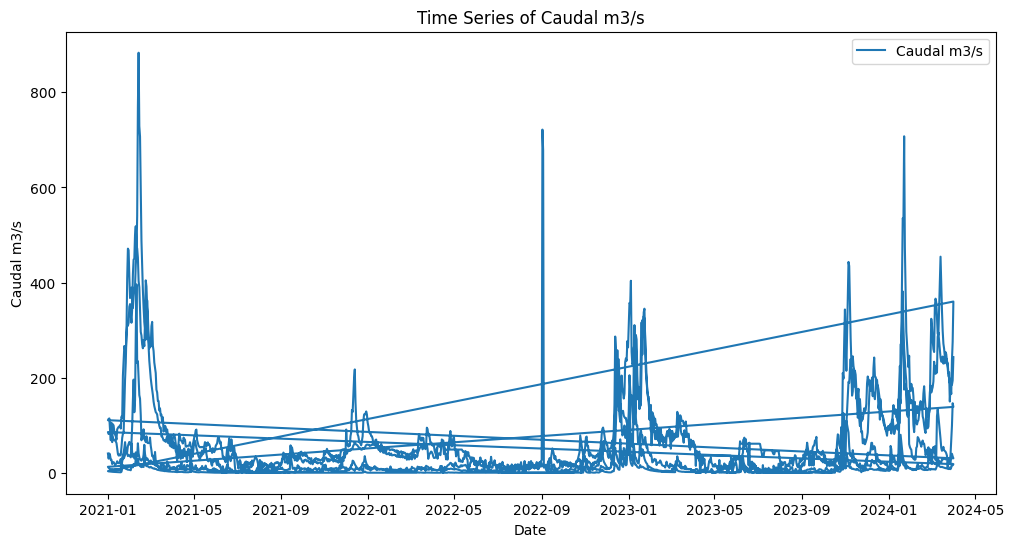

In [29]:
# Assuming target_train is already defined and contains the time series data

# Plot the time series data

plt.figure(figsize=(12, 6))

plt.plot(target_train['time'], target_train['caudal_m3/s'], label='Caudal m3/s')

plt.xlabel('Date')

plt.ylabel('Caudal m3/s')

plt.title('Time Series of Caudal m3/s')

plt.legend()

plt.show()

Creamos variables que permitan que el modelo entienda la temporalidad.

In [30]:
# feature engineering

model_df2 = create_time_feature(model_df) #Añadir nuevas variables de tiempo que ayuden al modelo a capturar patrones temporales más complejos.



# Establece la columna "time" como índice del DataFrame

model_df2.set_index("time", inplace=True)

In [31]:
# feature engineering

model_df_sin_nuevos_datos = create_time_feature(model_df_sin_nuevos_datos) #Añadir nuevas variables de tiempo que ayuden al modelo a capturar patrones temporales más complejos.



# Establece la columna "time" como índice del DataFrame

model_df_sin_nuevos_datos.set_index("time", inplace=True)

Para este ejemplo usaremos todos los datos hasta la primera fecha de train para entrenar nuestro modelo. Este es un notebook ejemplo, por tanto no empleamos estrategias de testing. Recomendamos que vosotros si empleéis estrategias más elaboradas, como *backtesting*.

### Empezamos a entrenar los modelos predictivos



En este caso vamos a entrenar dos modelos *xgboost*: uno a 24 horas y otro a 48 horas. Es posible que podáis ganar eficiencia y poder predictivo si usáis un modelo que prediga ambos horizontes temporales. Podéis experimentar con esto y pensar en por que puede ser o no puede ser el caso.


In [32]:
#dates_for_pred = [date - pd.DateOffset(days=1) for date in test_dates[::2]]

#dates_for_pred

In [33]:
test_set_dates = [

    '2023-04-16','2023-04-17',

    '2023-05-07','2023-05-08',

    '2023-06-12','2023-06-13',

    '2023-07-09','2023-07-10',

    '2023-08-04','2023-08-05',

    '2023-09-09','2023-09-10',

    '2023-09-30','2023-10-01'

]

In [34]:
test_set_dates2 = [

    '2023-11-07','2023-11-08',

    '2023-12-07','2023-12-08',

    '2023-12-29','2023-12-30',

    '2024-01-22','2024-01-23',

    '2024-02-16','2024-02-17',

    '2024-03-15','2024-03-16'

]

In [35]:
all_test_set_dates = [

    '2023-04-16','2023-04-17',

    '2023-05-07','2023-05-08',

    '2023-06-12','2023-06-13',

    '2023-07-09','2023-07-10',

    '2023-08-04','2023-08-05',

    '2023-09-09','2023-09-10',

    '2023-09-30','2023-10-01',

    '2023-11-07','2023-11-08',

    '2023-12-07','2023-12-08',

    '2023-12-29','2023-12-30',

    '2024-01-22','2024-01-23',

    '2024-02-16','2024-02-17',

    '2024-03-15','2024-03-16'

]

In [36]:
test_set_dates = pd.to_datetime(test_set_dates)

test_set_dates2 = pd.to_datetime(test_set_dates2)

In [37]:
dates_for_test = [date - pd.DateOffset(days=1) for date in test_set_dates[::2]]

dates_for_test

[Timestamp('2023-04-15 00:00:00'),
 Timestamp('2023-05-06 00:00:00'),
 Timestamp('2023-06-11 00:00:00'),
 Timestamp('2023-07-08 00:00:00'),
 Timestamp('2023-08-03 00:00:00'),
 Timestamp('2023-09-08 00:00:00'),
 Timestamp('2023-09-29 00:00:00')]

In [38]:
dates_for_test2 = [date - pd.DateOffset(days=1) for date in test_set_dates2[::2]]

dates_for_test2

[Timestamp('2023-11-06 00:00:00'),
 Timestamp('2023-12-06 00:00:00'),
 Timestamp('2023-12-28 00:00:00'),
 Timestamp('2024-01-21 00:00:00'),
 Timestamp('2024-02-15 00:00:00'),
 Timestamp('2024-03-14 00:00:00')]

In [39]:
pred_set_dates = ['2023-04-12','2023-04-13',

                  '2023-05-03','2023-05-04',

                  '2023-06-08','2023-06-09',

                  '2023-07-05','2023-07-06',

                  '2023-07-31','2023-08-01',

                  '2023-09-05','2023-09-06',

                  '2023-09-26','2023-09-27']

In [40]:
pred_set_dates2 = ['2023-11-03','2023-11-04',

                   '2023-12-03','2023-12-04',

                   '2023-12-25','2023-12-26',

                   '2024-01-18','2024-01-19',

                   '2024-02-12','2024-02-13',

                   '2024-03-11','2024-03-12']

In [41]:
pred_set_dates = pd.to_datetime(pred_set_dates)

pred_set_dates2 = pd.to_datetime(pred_set_dates2)

In [42]:
dates_for_pred = [date - pd.DateOffset(days=1) for date in pred_set_dates[::2]]

dates_for_pred

[Timestamp('2023-04-11 00:00:00'),
 Timestamp('2023-05-02 00:00:00'),
 Timestamp('2023-06-07 00:00:00'),
 Timestamp('2023-07-04 00:00:00'),
 Timestamp('2023-07-30 00:00:00'),
 Timestamp('2023-09-04 00:00:00'),
 Timestamp('2023-09-25 00:00:00')]

In [43]:
dates_for_pred2 = [date - pd.DateOffset(days=1) for date in pred_set_dates2[::2]]

dates_for_pred2

[Timestamp('2023-11-02 00:00:00'),
 Timestamp('2023-12-02 00:00:00'),
 Timestamp('2023-12-24 00:00:00'),
 Timestamp('2024-01-17 00:00:00'),
 Timestamp('2024-02-11 00:00:00'),
 Timestamp('2024-03-10 00:00:00')]

In [44]:
# Filtrar las fechas del conjunto de prueba en el DataFrame de emplazamientos

test_df_emplazamientos = target_train[target_train['time'].isin(all_test_set_dates)]



# Mostrar las columnas del DataFrame de prueba para verificar

print("Columnas del DataFrame de prueba:")

print(test_df_emplazamientos.columns)



# Mostrar las fechas y sus correspondientes valores de caudal

print("Fechas y sus correspondientes valores de caudal en el conjunto de prueba:")

print(test_df_emplazamientos[['time', 'caudal_m3/s']])



# Ensure the DataFrame has a 'name' column

if 'name' not in test_df_emplazamientos.columns:

    test_df_emplazamientos['name'] = 'Emplazamiento 0'  # Default name if not present



# Combine 'time' and 'name' into a new column 'time_name'

test_df_emplazamientos['time_name'] = test_df_emplazamientos['time'].dt.strftime('%Y-%m-%d') + '_' + test_df_emplazamientos['name']



# Drop the original 'time' and 'name' columns

test_set = test_df_emplazamientos[['time_name','caudal_m3/s']]



# Print the test_set DataFrame to verify the new column

print("Test set with combined time and name:")

print(test_set)

Columnas del DataFrame de prueba:

Index(['time', 'codigo', 'caudal_m3/s', 'latitude', 'longitude', 'name'], dtype='object')

Fechas y sus correspondientes valores de caudal en el conjunto de prueba:

           time  caudal_m3/s

833  2023-04-16       6.2660

834  2023-04-17       7.3980

852  2023-05-07       4.4605

853  2023-05-08       2.3020

886  2023-06-12       4.0030

...         ...          ...

5735 2024-01-23     474.2340

5757 2024-02-16     134.8260

5758 2024-02-17     133.9670

5783 2024-03-15     341.2690

5784 2024-03-16     298.3710



[130 rows x 2 columns]

Test set with combined time and name:

                       time_name  caudal_m3/s

833   2023-04-16_Emplazamiento 0       6.2660

834   2023-04-17_Emplazamiento 0       7.3980

852   2023-05-07_Emplazamiento 0       4.4605

853   2023-05-08_Emplazamiento 0       2.3020

886   2023-06-12_Emplazamiento 0       4.0030

...                          ...          ...

5735  2024-01-23_Emplazamiento 4     474.2340

C:\Users\belv2\AppData\Local\Temp\ipykernel_2500\144453691.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.

  test_df_emplazamientos = target_train[target_train['time'].isin(all_test_set_dates)]


In [45]:
model_df = model_df[[

    ('caudal_m3/s', 'Aforo 0'), ('caudal_m3/s', 'Aforo 2'), ('caudal_m3/s', 'Aforo 3'), ('caudal_m3/s', 'Aforo 9'),  

    'dayofyear', 'var255 of table 3 of center 7_0_10_DBLY_6', 'Year cos', 'dayofmonth', ('caudal_m3/s', 'Aforo 10'), 

    ('caudal_m3/s', 'Aforo 1'), 'Year sin', 'VIS_0_SFC_12', 'year', 'PEVPR_0_SFC_48', ('caudal_m3/s', 'Aforo 5'), ('caudal_m3/s', 'Aforo 7'), ('caudal_m3/s', 'Aforo 8'), 

    'PEVPR_0_SFC_42', 'HPBL_0_SFC_12', 'VGRD_10_HTGL_12', 'var255 of table 3 of center 7_0_10_DBLY_12', 

    'PEVPR_0_SFC_18', 'LHTFL_0_SFC_48', 'VGRD_10_HTGL_24', 'HPBL_0_SFC_6', 'VGRD_10_HTGL_48', 

    ('caudal_m3/s', 'Aforo 4'), 'VGRD_10_HTGL_42', 'SHTFL_0_SFC_48', 'PEVPR_0_SFC_6', 'DLWRF_0_SFC_48', 

    'UGRD_10_HTGL_6', 'LHTFL_0_SFC_6', 'VGRD_10_HTGL_18', 'UGRD_10_HTGL_48', 'VIS_0_SFC_48', 

    'SHTFL_0_SFC_6', 'DSWRF_0_SFC_36', 'HPBL_0_SFC_36', 'var255 of table 3 of center 7_0_10_DBLY_30', 

    'SHTFL_0_SFC_12', 'HPBL_0_SFC_18', 'VGRD_10_HTGL_6', 'LHTFL_0_SFC_24', 'PEVPR_0_SFC_30', 

    'HPBL_0_SFC_30', 'SHTFL_0_SFC_30', 'PEVPR_0_SFC_12', 'HPBL_0_SFC_48', 'VGRD_10_HTGL_36', 

    'PEVPR_0_SFC_24', 'VIS_0_SFC_6', 'UGRD_10_HTGL_12', 'VGRD_10_HTGL_30', 'SHTFL_0_SFC_18', 

    'LHTFL_0_SFC_12', 'LHTFL_0_SFC_18', 'HPBL_0_SFC_42', 'HPBL_0_SFC_24', 'SHTFL_0_SFC_24', 

    'LHTFL_0_SFC_36', 'SHTFL_0_SFC_36', 'PEVPR_0_SFC_36', 'LHTFL_0_SFC_42', 'DSWRF_0_SFC_12', 

    'SHTFL_0_SFC_42', 'DLWRF_0_SFC_36', 'UGRD_10_HTGL_18', 'DPT_2_HTGL_48', 'DPT_2_HTGL_42', 

    'DPT_2_HTGL_36', 'LHTFL_0_SFC_30', 'USWRF_0_SFC_12', 'DLWRF_0_SFC_6', 'UGRD_10_HTGL_30', 

    'UGRD_10_HTGL_36', 'DPT_2_HTGL_12', 'var255 of table 3 of center 7_0_10_DBLY_36', 'DLWRF_0_SFC_18','Emplazamiento 0','Emplazamiento 1','Emplazamiento 2','Emplazamiento 3', 'Emplazamiento 4'

]]

In [46]:
def create_sequences(data, time_steps=4):

    X = []

    for i in range(len(data) - time_steps):

        X.append(data[i:i + time_steps])

    return np.array(X)



# Convertir test_dates a datetime

test_dates = pd.to_datetime(pred_set_dates)



# Inicializar una lista vacía para almacenar predicciones

predictions = []



training_counter = 0

time_steps = 4  # Número de pasos anteriores que usaremos en las secuencias



# Normalizadores para las características y las variables objetivo

scaler_features = MinMaxScaler(feature_range=(0, 1))

scalers_target = {

    'caudal_m3/s_24h_lead': MinMaxScaler(feature_range=(0, 1)),

    'caudal_m3/s_48h_lead': MinMaxScaler(feature_range=(0, 1))

}



# Emplazamientos a iterar

emplazamientos = y_targets['name'].unique()



# Iterar a través de cada emplazamiento

for emplazamiento in emplazamientos:

    print(f"Processing {emplazamiento}...")



    # Filtrar el conjunto de objetivos por el emplazamiento actual

    y_targets_emp = y_targets[y_targets['name'] == emplazamiento]



    # Iterar a través de cada fecha en test_dates

    for current_date in dates_for_pred:

        print(f"Current date: {current_date}")

        

        model_df_train = model_df[model_df.index < current_date].copy()

        # Seleccionar datos de entrenamiento hasta la fecha actual

        y_targets_train = y_targets_emp[y_targets_emp["time"] < current_date].copy()



        # Mascar las fechas de prueba en el conjunto de entrenamiento

        model_df_train.loc[model_df_train.index.isin(test_dates), :] = np.nan

        y_targets_train.loc[y_targets_train["time"].isin(test_dates), "caudal_m3/s_24h_lead"] = np.nan

        y_targets_train.loc[y_targets_train["time"].isin(test_dates), "caudal_m3/s_48h_lead"] = np.nan



        # Eliminar filas donde las variables objetivo son NaN

        model_df_train = model_df_train.dropna()

        y_targets_train = y_targets_train.dropna()



        if 'time' not in y_targets_train.columns:

            y_targets_train = y_targets_train.reset_index()



        # Asegurar que hay suficientes datos para entrenar el modelo

        if len(model_df_train) > 0 and len(y_targets_train) > 0:

            # Alinear índices de características y etiquetas

            model_df_train, y_targets_train = model_df_train.align(y_targets_train.set_index('time'), join='inner', axis=0)

            

            model_df_train.columns = model_df_train.columns.map(str)  # Asegurarse de que los nombres de las columnas sean strings

            y_targets_train.columns = y_targets_train.columns.map(str)



            # Normalizar las características y las etiquetas

            model_df_train_scaled = scaler_features.fit_transform(model_df_train)

            y_train_scaled = {

                'caudal_m3/s_24h_lead': scalers_target['caudal_m3/s_24h_lead'].fit_transform(y_targets_train['caudal_m3/s_24h_lead'].values.reshape(-1, 1)),

                'caudal_m3/s_48h_lead': scalers_target['caudal_m3/s_48h_lead'].fit_transform(y_targets_train['caudal_m3/s_48h_lead'].values.reshape(-1, 1))

            }



            # Crear secuencias para las características

            X_train = create_sequences(model_df_train_scaled, time_steps)



            # Crear secuencias para las etiquetas (tanto de 24h como de 48h)

            y_train_24h = y_train_scaled['caudal_m3/s_24h_lead'][time_steps:]

            y_train_48h = y_train_scaled['caudal_m3/s_48h_lead'][time_steps:]



            # Definir modelos LSTM

            def build_lstm_model():

                model = Sequential()

                model.add(LSTM(units=64, return_sequences=True, input_shape=(time_steps, X_train.shape[2])))

                model.add(Dropout(0.2))

                model.add(LSTM(units=64))

                model.add(Dropout(0.2))

                model.add(Dense(1))

                optimizer = RMSprop(learning_rate=0.001)

                model.compile(optimizer=optimizer, loss='mean_squared_error')

                return model



            # Entrenar modelos

            print(f"Training LSTM model for 24h prediction for {emplazamiento}...")

            lstm_24h = build_lstm_model()

            lstm_24h.fit(X_train, y_train_24h, epochs=10, batch_size=32, validation_split=0.2)



            print(f"Training LSTM model for 48h prediction for {emplazamiento}...")

            lstm_48h = build_lstm_model()

            lstm_48h.fit(X_train, y_train_48h, epochs=10, batch_size=32, validation_split=0.2)



            # Hacer predicciones para la fecha actual

            test_data = model_df[model_df.index == current_date].copy()

            if not test_data.empty:

                

                test_data.columns = test_data.columns.map(str)

                # Escalar las características del conjunto de prueba

                test_data_scaled = scaler_features.transform(test_data)

                X_test_data = create_sequences(test_data_scaled, time_steps)



                if X_test_data.shape[0] > 0:

                    # Predicciones a 24h

                    pred_24h = lstm_24h.predict(X_test_data)

                    pred_24h = scalers_target['caudal_m3/s_24h_lead'].inverse_transform(pred_24h)



                    # Predicciones a 48h

                    pred_48h = lstm_48h.predict(X_test_data)

                    pred_48h = scalers_target['caudal_m3/s_48h_lead'].inverse_transform(pred_48h)



                    # Preparar las predicciones para guardarlas

                    idx_24h = get_prediction_index(test_data, 24)

                    idx_48h = get_prediction_index(test_data, 48)



                    if 'time' not in idx_24h.columns:

                        idx_24h['time'] = test_data.index

                    if 'time' not in idx_48h.columns:

                        idx_48h['time'] = test_data.index



                    # Guardar predicciones con información de emplazamiento

                    idx_24h["caudal_m3/s"] = pd.Series(pred_24h.flatten())

                    idx_48h["caudal_m3/s"] = pd.Series(pred_48h.flatten())

                    idx_24h["name"] = emplazamiento

                    idx_48h["name"] = emplazamiento



                    predictions.append(idx_24h)

                    predictions.append(idx_48h)

                else:

                    print(f"X_test_data is empty for {current_date}. No predictions made.")

            else:

                print(f"No test data available for {current_date}.")

        else:

            print(f"Not enough data to train the model for {current_date}.")



predictions_df = pd.concat(predictions, axis=0).reset_index(drop=True)

    

# Create the 'time_name' column by combining 'time' and 'name'

predictions_df['time_name'] = predictions_df['time'].astype(str) + "_" + predictions_df['name']



# Now, select the correct columns for the final submission_df

submission_df = predictions_df[['time_name', 'caudal_m3/s']]



# Save the predictions to CSV

submission_df.to_csv("submission.csv", index=False)


Processing Emplazamiento 0...

Current date: 2023-04-11 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 0...

Epoch 1/10

87/92 [===========================>..] - ETA: 0s - loss: 0.0091

[codecarbon INFO @ 03:27:01] Energy consumed for RAM : 0.000150 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:27:01] Energy consumed for all GPUs : 0.000398 kWh. Total GPU Power : 55.62198522649817 W

[codecarbon INFO @ 03:27:01] Energy consumed for all CPUs : 0.000406 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:27:01] 0.000954 kWh of electricity used since the beginning.


92/92 [==============================] - 4s 12ms/step - loss: 0.0090 - val_loss: 0.0053

Epoch 2/10

92/92 [==============================] - 1s 7ms/step - loss: 0.0055 - val_loss: 0.0050

Epoch 3/10

92/92 [==============================] - 1s 7ms/step - loss: 0.0046 - val_loss: 0.0045

Epoch 4/10

92/92 [==============================] - 1s 7ms/step - loss: 0.0039 - val_loss: 0.0040

Epoch 5/10

92/92 [==============================] - 1s 7ms/step - loss: 0.0039 - val_loss: 0.0035

Epoch 6/10

92/92 [==============================] - 1s 7ms/step - loss: 0.0028 - val_loss: 0.0037

Epoch 7/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0036

Epoch 8/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0040

Epoch 9/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0024

Epoch 10/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0018

Training L

[codecarbon INFO @ 03:27:16] Energy consumed for RAM : 0.000199 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:27:16] Energy consumed for all GPUs : 0.000595 kWh. Total GPU Power : 47.33787374647669 W

[codecarbon INFO @ 03:27:16] Energy consumed for all CPUs : 0.000542 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:27:16] 0.001337 kWh of electricity used since the beginning.


Epoch 1/10

95/95 [==============================] - 3s 14ms/step - loss: 0.0101 - val_loss: 0.0081

Epoch 2/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0055 - val_loss: 0.0044

Epoch 3/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0045 - val_loss: 0.0048

Epoch 4/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0041 - val_loss: 0.0040

Epoch 5/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0023

Epoch 6/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0018

Epoch 7/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0014

Epoch 8/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0016

Epoch 9/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0015

Epoch 10/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0012

[codecarbon INFO @ 03:27:31] Energy consumed for RAM : 0.000249 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:27:31] Energy consumed for all GPUs : 0.000735 kWh. Total GPU Power : 33.51986756074776 W

[codecarbon INFO @ 03:27:31] Energy consumed for all CPUs : 0.000677 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:27:31] 0.001662 kWh of electricity used since the beginning.


95/95 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0036

Epoch 9/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0025

Epoch 10/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0022

1/1 [==============================] - 0s 350ms/step

1/1 [==============================] - 0s 349ms/step

Current date: 2023-06-07 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 0...

Epoch 1/10

99/99 [==============================] - 3s 11ms/step - loss: 0.0087 - val_loss: 0.0061

Epoch 2/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0051 - val_loss: 0.0036

Epoch 3/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0041 - val_loss: 0.0037

Epoch 4/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0036 - val_loss: 0.0032

Epoch 5/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0045

Epoc

[codecarbon INFO @ 03:27:46] Energy consumed for RAM : 0.000299 kWh. RAM Power : 11.96253490447998 W



10/99 [==>...........................] - ETA: 0s - loss: 0.0013    

[codecarbon INFO @ 03:27:46] Energy consumed for all GPUs : 0.000860 kWh. Total GPU Power : 30.08570818812368 W

[codecarbon INFO @ 03:27:46] Energy consumed for all CPUs : 0.000813 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:27:46] 0.001972 kWh of electricity used since the beginning.


99/99 [==============================] - 1s 6ms/step - loss: 0.0040 - val_loss: 0.0040

Epoch 5/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0033

Epoch 6/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0020

Epoch 7/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0033

Epoch 8/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0022

Epoch 9/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0018

Epoch 10/10

99/99 [==============================] - 1s 7ms/step - loss: 0.0025 - val_loss: 0.0031


1/1 [==============================] - 0s 347ms/step


1/1 [==============================] - 0s 347ms/step

Current date: 2023-07-04 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 0...

Epoch 1/10

102/102 [==============================] - 3s 11ms/step - loss: 0.0085 - val_loss: 0.0052



[codecarbon INFO @ 03:28:01] Energy consumed for RAM : 0.000349 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:28:01] Energy consumed for all GPUs : 0.000990 kWh. Total GPU Power : 31.193589131546116 W

[codecarbon INFO @ 03:28:01] Energy consumed for all CPUs : 0.000948 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:28:01] 0.002288 kWh of electricity used since the beginning.


102/102 [==============================] - 3s 11ms/step - loss: 0.0084 - val_loss: 0.0052

Epoch 2/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0054 - val_loss: 0.0055

Epoch 3/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0047 - val_loss: 0.0035

Epoch 4/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0038 - val_loss: 0.0042

Epoch 5/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0027

Epoch 6/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0023

Epoch 7/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0021

Epoch 8/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0016

Epoch 9/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0018

Epoch 10/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss

[codecarbon INFO @ 03:28:16] Energy consumed for RAM : 0.000399 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:28:16] Energy consumed for all GPUs : 0.001105 kWh. Total GPU Power : 27.462211254357697 W

[codecarbon INFO @ 03:28:16] Energy consumed for all CPUs : 0.001084 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:28:16] 0.002587 kWh of electricity used since the beginning.

[codecarbon INFO @ 03:28:16] 0.003751 g.CO2eq/s mean an estimation of 118.28181856509792 kg.CO2eq/year


105/105 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0027

Epoch 7/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0018

Epoch 8/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0012

Epoch 9/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0024

Epoch 10/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0027

Training LSTM model for 48h prediction for Emplazamiento 0...

Epoch 1/10

105/105 [==============================] - 3s 10ms/step - loss: 0.0077 - val_loss: 0.0052

Epoch 2/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0048 - val_loss: 0.0053

Epoch 3/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0042 - val_loss: 0.0047

Epoch 4/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0043

Epoch 5/10

105/105 [========

[codecarbon INFO @ 03:28:31] Energy consumed for RAM : 0.000449 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:28:31] Energy consumed for all GPUs : 0.001220 kWh. Total GPU Power : 27.7061089957557 W

[codecarbon INFO @ 03:28:31] Energy consumed for all CPUs : 0.001219 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:28:31] 0.002888 kWh of electricity used since the beginning.


109/109 [==============================] - 3s 11ms/step - loss: 0.0078 - val_loss: 0.0043

Epoch 2/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0046 - val_loss: 0.0052

Epoch 3/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0039 - val_loss: 0.0052

Epoch 4/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0039

Epoch 5/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0028

Epoch 6/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0021

Epoch 7/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0017

Epoch 8/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0021

Epoch 9/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0018 - val_loss: 0.0035

Epoch 10/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0018 - val_loss

[codecarbon INFO @ 03:28:46] Energy consumed for RAM : 0.000499 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:28:46] Energy consumed for all GPUs : 0.001341 kWh. Total GPU Power : 28.97028026212044 W

[codecarbon INFO @ 03:28:46] Energy consumed for all CPUs : 0.001355 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:28:46] 0.003194 kWh of electricity used since the beginning.


109/109 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0015

Epoch 10/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0013

1/1 [==============================] - 1s 688ms/step

1/1 [==============================] - 0s 359ms/step

Current date: 2023-09-25 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 0...

Epoch 1/10

112/112 [==============================] - 3s 11ms/step - loss: 0.0081 - val_loss: 0.0069

Epoch 2/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0045 - val_loss: 0.0038

Epoch 3/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0042 - val_loss: 0.0030

Epoch 4/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0031

Epoch 5/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0028

Epoch 6/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0024 - val_lo

[codecarbon INFO @ 03:29:01] Energy consumed for RAM : 0.000548 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:29:02] Energy consumed for all GPUs : 0.001466 kWh. Total GPU Power : 29.91651439360382 W

[codecarbon INFO @ 03:29:02] Energy consumed for all CPUs : 0.001490 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:29:02] 0.003504 kWh of electricity used since the beginning.


112/112 [==============================] - 1s 6ms/step - loss: 0.0050 - val_loss: 0.0034

Epoch 3/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0041 - val_loss: 0.0067

Epoch 4/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0031

Epoch 5/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0029

Epoch 6/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0024

Epoch 7/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0021

Epoch 8/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0020

Epoch 9/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0027

Epoch 10/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0015

1/1 [==============================] - 0s 352ms/step

1/1 [==============================] - 

[codecarbon INFO @ 03:29:17] Energy consumed for RAM : 0.000598 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:29:17] Energy consumed for all GPUs : 0.001586 kWh. Total GPU Power : 28.80347851627958 W

[codecarbon INFO @ 03:29:17] Energy consumed for all CPUs : 0.001626 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:29:17] 0.003810 kWh of electricity used since the beginning.


Epoch 1/10

92/92 [==============================] - 3s 11ms/step - loss: 0.0093 - val_loss: 0.0050

Epoch 2/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0053 - val_loss: 0.0048

Epoch 3/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0045 - val_loss: 0.0055

Epoch 4/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0044 - val_loss: 0.0037

Epoch 5/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0039 - val_loss: 0.0040

Epoch 6/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0040 - val_loss: 0.0035

Epoch 7/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0036 - val_loss: 0.0034

Epoch 8/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0032

Epoch 9/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0033

Epoch 10/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0032

[codecarbon INFO @ 03:29:32] Energy consumed for RAM : 0.000648 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:29:32] Energy consumed for all GPUs : 0.001700 kWh. Total GPU Power : 27.371895227317086 W

[codecarbon INFO @ 03:29:32] Energy consumed for all CPUs : 0.001761 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:29:32] 0.004109 kWh of electricity used since the beginning.


95/95 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0028

Epoch 8/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0036

Epoch 9/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0024

Epoch 10/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0016

Training LSTM model for 48h prediction for Emplazamiento 1...

Epoch 1/10

95/95 [==============================] - 3s 11ms/step - loss: 0.0096 - val_loss: 0.0050

Epoch 2/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0051 - val_loss: 0.0050

Epoch 3/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0044 - val_loss: 0.0039

Epoch 4/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0041 - val_loss: 0.0036

Epoch 5/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0040 - val_loss: 0.0041

Epoch 6/10

95/95 [============================

[codecarbon INFO @ 03:29:47] Energy consumed for RAM : 0.000698 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:29:47] Energy consumed for all GPUs : 0.001813 kWh. Total GPU Power : 27.264392855462674 W

[codecarbon INFO @ 03:29:47] Energy consumed for all CPUs : 0.001897 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:29:47] 0.004408 kWh of electricity used since the beginning.


99/99 [==============================] - 1s 7ms/step - loss: 0.0037 - val_loss: 0.0039

Epoch 4/10

99/99 [==============================] - 1s 7ms/step - loss: 0.0034 - val_loss: 0.0043

Epoch 5/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0044

Epoch 6/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0026

Epoch 7/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0022

Epoch 8/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0018

Epoch 9/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0026

Epoch 10/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0017

Training LSTM model for 48h prediction for Emplazamiento 1...

Epoch 1/10

99/99 [==============================] - 3s 11ms/step - loss: 0.0086 - val_loss: 0.0053

Epoch 2/10

99/99 [============================

[codecarbon INFO @ 03:30:02] Energy consumed for RAM : 0.000748 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:30:02] Energy consumed for all GPUs : 0.001944 kWh. Total GPU Power : 31.361734585151417 W

[codecarbon INFO @ 03:30:02] Energy consumed for all CPUs : 0.002032 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:30:02] 0.004724 kWh of electricity used since the beginning.


102/102 [==============================] - 3s 14ms/step - loss: 0.0069 - val_loss: 0.0039

Epoch 2/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0041 - val_loss: 0.0046

Epoch 3/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0036

Epoch 4/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0026

Epoch 5/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0033

Epoch 6/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0026

Epoch 7/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0026

Epoch 8/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0019

Epoch 9/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0030

Epoch 10/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss

[codecarbon INFO @ 03:30:17] Energy consumed for RAM : 0.000798 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:30:17] Energy consumed for all GPUs : 0.002059 kWh. Total GPU Power : 27.569289341086925 W

[codecarbon INFO @ 03:30:17] Energy consumed for all CPUs : 0.002168 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:30:17] 0.005024 kWh of electricity used since the beginning.

[codecarbon INFO @ 03:30:17] 0.003533 g.CO2eq/s mean an estimation of 111.40141610251865 kg.CO2eq/year


102/102 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0037

Epoch 8/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0030

Epoch 9/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0028

Epoch 10/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0024

1/1 [==============================] - 0s 350ms/step

1/1 [==============================] - 0s 348ms/step

Current date: 2023-07-30 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 1...

Epoch 1/10

105/105 [==============================] - 3s 11ms/step - loss: 0.0097 - val_loss: 0.0042

Epoch 2/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0045 - val_loss: 0.0031

Epoch 3/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0036 - val_loss: 0.0044

Epoch 4/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0031 - val_lo

[codecarbon INFO @ 03:30:32] Energy consumed for RAM : 0.000847 kWh. RAM Power : 11.96253490447998 W



105/105 [==============================] - ETA: 0s - loss: 0.0083

[codecarbon INFO @ 03:30:32] Energy consumed for all GPUs : 0.002174 kWh. Total GPU Power : 27.661133573647472 W

[codecarbon INFO @ 03:30:32] Energy consumed for all CPUs : 0.002303 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:30:32] 0.005325 kWh of electricity used since the beginning.


105/105 [==============================] - 3s 10ms/step - loss: 0.0083 - val_loss: 0.0063

Epoch 2/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0046 - val_loss: 0.0038

Epoch 3/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0042 - val_loss: 0.0035

Epoch 4/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0038 - val_loss: 0.0042

Epoch 5/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0036 - val_loss: 0.0034

Epoch 6/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0035

Epoch 7/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0042

Epoch 8/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0046

Epoch 9/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0034

Epoch 10/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss

[codecarbon INFO @ 03:30:47] Energy consumed for RAM : 0.000897 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:30:47] Energy consumed for all GPUs : 0.002292 kWh. Total GPU Power : 28.353054888594507 W

[codecarbon INFO @ 03:30:47] Energy consumed for all CPUs : 0.002438 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:30:47] 0.005628 kWh of electricity used since the beginning.


109/109 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0028

Epoch 9/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0017

Epoch 10/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0017

Training LSTM model for 48h prediction for Emplazamiento 1...

Epoch 1/10

109/109 [==============================] - 3s 10ms/step - loss: 0.0074 - val_loss: 0.0045

Epoch 2/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0046 - val_loss: 0.0041

Epoch 3/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0038 - val_loss: 0.0048

Epoch 4/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0040

Epoch 5/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0060

Epoch 6/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0054

Epoch 7/10

109/109 [========

[codecarbon INFO @ 03:31:02] Energy consumed for RAM : 0.000947 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:31:02] Energy consumed for all GPUs : 0.002406 kWh. Total GPU Power : 27.174605524082512 W

[codecarbon INFO @ 03:31:02] Energy consumed for all CPUs : 0.002574 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:31:02] 0.005927 kWh of electricity used since the beginning.


112/112 [==============================] - 1s 6ms/step - loss: 0.0040 - val_loss: 0.0037

Epoch 3/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0029

Epoch 4/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0107

Epoch 5/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0034

Epoch 6/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0022

Epoch 7/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0020

Epoch 8/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0023

Epoch 9/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0018

Epoch 10/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0017

Training LSTM model for 48h prediction for Emplazamiento 1...

Epoch 1/10

112/112 [=========

[codecarbon INFO @ 03:31:17] Energy consumed for RAM : 0.000997 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:31:17] Energy consumed for all GPUs : 0.002529 kWh. Total GPU Power : 29.48964054160815 W

[codecarbon INFO @ 03:31:17] Energy consumed for all CPUs : 0.002709 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:31:17] 0.006235 kWh of electricity used since the beginning.


112/112 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0028

1/1 [==============================] - 0s 347ms/step

1/1 [==============================] - 1s 689ms/step

Processing Emplazamiento 2...

Current date: 2023-04-11 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 2...

Epoch 1/10

92/92 [==============================] - 3s 11ms/step - loss: 0.0060 - val_loss: 0.0035

Epoch 2/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0039 - val_loss: 0.0035

Epoch 3/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0032

Epoch 4/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0031

Epoch 5/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0036

Epoch 6/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0029

Epoch 7/10

92/92 [==============================] - 1s 6ms/step - loss:

[codecarbon INFO @ 03:31:32] Energy consumed for RAM : 0.001047 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:31:32] Energy consumed for all GPUs : 0.002641 kWh. Total GPU Power : 27.011148530453717 W

[codecarbon INFO @ 03:31:32] Energy consumed for all CPUs : 0.002845 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:31:32] 0.006533 kWh of electricity used since the beginning.


92/92 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0031

Epoch 8/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0033

Epoch 9/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0031

Epoch 10/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0030

1/1 [==============================] - 0s 349ms/step

1/1 [==============================] - 1s 695ms/step

Current date: 2023-05-02 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 2...

Epoch 1/10

95/95 [==============================] - 3s 12ms/step - loss: 0.0066 - val_loss: 0.0055

Epoch 2/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0038 - val_loss: 0.0116

Epoch 3/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0039

Epoch 4/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0057

Epoc

[codecarbon INFO @ 03:31:47] Energy consumed for RAM : 0.001097 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:31:47] Energy consumed for all GPUs : 0.002754 kWh. Total GPU Power : 27.026586272324884 W

[codecarbon INFO @ 03:31:47] Energy consumed for all CPUs : 0.002980 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:31:47] 0.006831 kWh of electricity used since the beginning.


95/95 [==============================] - 1s 6ms/step - loss: 0.0042 - val_loss: 0.0034

Epoch 3/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0039 - val_loss: 0.0052

Epoch 4/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0036 - val_loss: 0.0033

Epoch 5/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0031

Epoch 6/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0035

Epoch 7/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0040

Epoch 8/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0071

Epoch 9/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0038

Epoch 10/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0036

1/1 [==============================] - 1s 698ms/step

1/1 [==============================] - 0s 356ms/step

Cur

[codecarbon INFO @ 03:32:02] Energy consumed for RAM : 0.001147 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:32:02] Energy consumed for all GPUs : 0.002884 kWh. Total GPU Power : 31.24145436810265 W

[codecarbon INFO @ 03:32:02] Energy consumed for all CPUs : 0.003116 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:32:02] 0.007146 kWh of electricity used since the beginning.


99/99 [==============================] - 3s 14ms/step - loss: 0.0077 - val_loss: 0.0067

Epoch 2/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0041 - val_loss: 0.0033

Epoch 3/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0034

Epoch 4/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0040

Epoch 5/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0031

Epoch 6/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0031

Epoch 7/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0029

Epoch 8/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0034

Epoch 9/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0029

Epoch 10/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0028

1/1 [=====

[codecarbon INFO @ 03:32:17] Energy consumed for RAM : 0.001196 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:32:17] Energy consumed for all GPUs : 0.002997 kWh. Total GPU Power : 27.184519018845137 W

[codecarbon INFO @ 03:32:17] Energy consumed for all CPUs : 0.003251 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:32:17] 0.007445 kWh of electricity used since the beginning.



 74/102 [====================>.........] - ETA: 0s - loss: 0.0034

[codecarbon INFO @ 03:32:17] 0.003509 g.CO2eq/s mean an estimation of 110.67546891880727 kg.CO2eq/year


102/102 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0031

Epoch 7/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0028

Epoch 8/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0029

Epoch 9/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0031

Epoch 10/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0029

Training LSTM model for 48h prediction for Emplazamiento 2...

Epoch 1/10

102/102 [==============================] - 3s 11ms/step - loss: 0.0067 - val_loss: 0.0034

Epoch 2/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0038 - val_loss: 0.0033

Epoch 3/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0032

Epoch 4/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0030

Epoch 5/10

102/102 [========

[codecarbon INFO @ 03:32:32] Energy consumed for RAM : 0.001246 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:32:32] Energy consumed for all GPUs : 0.003112 kWh. Total GPU Power : 27.519966207725187 W

[codecarbon INFO @ 03:32:32] Energy consumed for all CPUs : 0.003387 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:32:32] 0.007745 kWh of electricity used since the beginning.


105/105 [==============================] - 3s 11ms/step - loss: 0.0063 - val_loss: 0.0031

Epoch 2/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0036 - val_loss: 0.0032

Epoch 3/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0028

Epoch 4/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0030

Epoch 5/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0031

Epoch 6/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0026

Epoch 7/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0027

Epoch 8/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0025

Epoch 9/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0026

Epoch 10/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss

[codecarbon INFO @ 03:32:47] Energy consumed for RAM : 0.001296 kWh. RAM Power : 11.96253490447998 W



 38/105 [=========>....................] - ETA: 0s - loss: 0.0020

[codecarbon INFO @ 03:32:47] Energy consumed for all GPUs : 0.003234 kWh. Total GPU Power : 29.20435817866323 W

[codecarbon INFO @ 03:32:47] Energy consumed for all CPUs : 0.003522 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:32:47] 0.008052 kWh of electricity used since the beginning.


105/105 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0032

1/1 [==============================] - 0s 344ms/step

1/1 [==============================] - 0s 349ms/step

Current date: 2023-09-04 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 2...

Epoch 1/10

109/109 [==============================] - 3s 11ms/step - loss: 0.0064 - val_loss: 0.0046

Epoch 2/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0029

Epoch 3/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0030

Epoch 4/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0029

Epoch 5/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0028

Epoch 6/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0028

Epoch 7/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0028 - val_los

[codecarbon INFO @ 03:33:02] Energy consumed for RAM : 0.001346 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:33:02] Energy consumed for all GPUs : 0.003347 kWh. Total GPU Power : 27.269957814868427 W

[codecarbon INFO @ 03:33:02] Energy consumed for all CPUs : 0.003658 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:33:02] 0.008351 kWh of electricity used since the beginning.


109/109 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0028

Epoch 5/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0031

Epoch 6/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0031

Epoch 7/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0027

Epoch 8/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0026

Epoch 9/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0025

Epoch 10/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0027

1/1 [==============================] - 0s 349ms/step

1/1 [==============================] - 0s 346ms/step

Current date: 2023-09-25 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 2...

Epoch 1/10

112/112 [==============================] - 3s 11ms/step - loss: 0.0061 - val_lo

[codecarbon INFO @ 03:33:17] Energy consumed for RAM : 0.001396 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:33:17] Energy consumed for all GPUs : 0.003467 kWh. Total GPU Power : 28.702634775676856 W

[codecarbon INFO @ 03:33:17] Energy consumed for all CPUs : 0.003793 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:33:17] 0.008656 kWh of electricity used since the beginning.


112/112 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0028

Training LSTM model for 48h prediction for Emplazamiento 2...

Epoch 1/10

112/112 [==============================] - 3s 10ms/step - loss: 0.0054 - val_loss: 0.0081

Epoch 2/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0041

Epoch 3/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0033

Epoch 4/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0028

Epoch 5/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0026

Epoch 6/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0027

Epoch 7/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0034

Epoch 8/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0029

Epoch 9/10

112/112 [=========

[codecarbon INFO @ 03:33:32] Energy consumed for RAM : 0.001446 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:33:32] Energy consumed for all GPUs : 0.003580 kWh. Total GPU Power : 27.161306889405214 W

[codecarbon INFO @ 03:33:32] Energy consumed for all CPUs : 0.003929 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:33:32] 0.008955 kWh of electricity used since the beginning.


92/92 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0014

Epoch 5/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0013

Epoch 6/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0017 - val_loss: 0.0015

Epoch 7/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0015 - val_loss: 0.0015

Epoch 8/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0014 - val_loss: 0.0110

Epoch 9/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0055

Epoch 10/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 7.3496e-04

Training LSTM model for 48h prediction for Emplazamiento 3...

Epoch 1/10

92/92 [==============================] - 3s 11ms/step - loss: 0.0058 - val_loss: 0.0032

Epoch 2/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0028

Epoch 3/10

92/92 [========================

[codecarbon INFO @ 03:33:47] Energy consumed for RAM : 0.001495 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:33:47] Energy consumed for all GPUs : 0.003694 kWh. Total GPU Power : 27.363197412560638 W

[codecarbon INFO @ 03:33:47] Energy consumed for all CPUs : 0.004064 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:33:47] 0.009254 kWh of electricity used since the beginning.


95/95 [==============================] - 3s 12ms/step - loss: 0.0071 - val_loss: 0.0030

Epoch 2/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0070

Epoch 3/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0030

Epoch 4/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0045

Epoch 5/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0018 - val_loss: 0.0030

Epoch 6/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0015 - val_loss: 0.0023

Epoch 7/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0021

Epoch 8/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0015 - val_loss: 0.0018

Epoch 9/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 7.3337e-04

Epoch 10/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0014 - val_loss: 0.0011

Traini

[codecarbon INFO @ 03:34:02] Energy consumed for RAM : 0.001545 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:34:02] Energy consumed for all GPUs : 0.003825 kWh. Total GPU Power : 31.410213512213623 W

[codecarbon INFO @ 03:34:02] Energy consumed for all CPUs : 0.004200 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:34:02] 0.009570 kWh of electricity used since the beginning.


1/1 [==============================] - 0s 357ms/step

Current date: 2023-06-07 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 3...

Epoch 1/10

99/99 [==============================] - 3s 11ms/step - loss: 0.0063 - val_loss: 0.0027

Epoch 2/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0021

Epoch 3/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0023

Epoch 4/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0027

Epoch 5/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0017 - val_loss: 0.0014

Epoch 6/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0018 - val_loss: 0.0021

Epoch 7/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 9.4814e-04

Epoch 8/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0026

Epoch 9/10

99/99 [========================

[codecarbon INFO @ 03:34:17] Energy consumed for RAM : 0.001595 kWh. RAM Power : 11.96253490447998 W



82/99 [=======================>......] - ETA: 0s - loss: 0.0023

[codecarbon INFO @ 03:34:17] Energy consumed for all GPUs : 0.003938 kWh. Total GPU Power : 27.216135942149755 W

[codecarbon INFO @ 03:34:17] Energy consumed for all CPUs : 0.004335 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:34:17] 0.009869 kWh of electricity used since the beginning.

[codecarbon INFO @ 03:34:17] 0.003514 g.CO2eq/s mean an estimation of 110.80973222460528 kg.CO2eq/year


99/99 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0037

Epoch 7/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0034

Epoch 8/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0016

Epoch 9/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0017 - val_loss: 0.0020

Epoch 10/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0016 - val_loss: 0.0028

1/1 [==============================] - 0s 350ms/step

1/1 [==============================] - 1s 697ms/step

Current date: 2023-07-04 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 3...

Epoch 1/10

102/102 [==============================] - 3s 11ms/step - loss: 0.0056 - val_loss: 0.0031

Epoch 2/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0046

Epoch 3/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0024

[codecarbon INFO @ 03:34:32] Energy consumed for RAM : 0.001645 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:34:32] Energy consumed for all GPUs : 0.004053 kWh. Total GPU Power : 27.479475105571918 W

[codecarbon INFO @ 03:34:32] Energy consumed for all CPUs : 0.004470 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:34:32] 0.010168 kWh of electricity used since the beginning.


102/102 [==============================] - 3s 11ms/step - loss: 0.0060 - val_loss: 0.0050

Epoch 2/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0026

Epoch 3/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0018

Epoch 4/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0029

Epoch 5/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0015

Epoch 6/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0028

Epoch 7/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0016 - val_loss: 0.0013

Epoch 8/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0016 - val_loss: 0.0230

Epoch 9/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0018 - val_loss: 0.0012

Epoch 10/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0016 - val_loss

[codecarbon INFO @ 03:34:47] Energy consumed for RAM : 0.001695 kWh. RAM Power : 11.96253490447998 W



 63/105 [=================>............] - ETA: 0s - loss: 0.0013

[codecarbon INFO @ 03:34:47] Energy consumed for all GPUs : 0.004170 kWh. Total GPU Power : 27.957581052909408 W

[codecarbon INFO @ 03:34:47] Energy consumed for all CPUs : 0.004606 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:34:47] 0.010470 kWh of electricity used since the beginning.


105/105 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 8.0194e-04

Epoch 9/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0010

Epoch 10/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0016

Training LSTM model for 48h prediction for Emplazamiento 3...

Epoch 1/10

105/105 [==============================] - 3s 11ms/step - loss: 0.0052 - val_loss: 0.0033

Epoch 2/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0028

Epoch 3/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0020

Epoch 4/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0025

Epoch 5/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0028

Epoch 6/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0015

Epoch 7/10

105/105 [====

[codecarbon INFO @ 03:35:02] Energy consumed for RAM : 0.001745 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:35:02] Energy consumed for all GPUs : 0.004283 kWh. Total GPU Power : 27.136708770639043 W

[codecarbon INFO @ 03:35:02] Energy consumed for all CPUs : 0.004741 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:35:02] 0.010769 kWh of electricity used since the beginning.


109/109 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0021

Epoch 3/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0024

Epoch 4/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0017 - val_loss: 0.0030

Epoch 5/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0018 - val_loss: 0.0020

Epoch 6/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0017 - val_loss: 0.0020

Epoch 7/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0021

Epoch 8/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0012

Epoch 9/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 6.8481e-04

Epoch 10/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 7.6507e-04

Training LSTM model for 48h prediction for Emplazamiento 3...

Epoch 1/10

109/109 [=

[codecarbon INFO @ 03:35:17] Energy consumed for RAM : 0.001795 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:35:17] Energy consumed for all GPUs : 0.004405 kWh. Total GPU Power : 29.31672760863451 W

[codecarbon INFO @ 03:35:17] Energy consumed for all CPUs : 0.004877 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:35:17] 0.011076 kWh of electricity used since the beginning.


109/109 [==============================] - 1s 6ms/step - loss: 0.0016 - val_loss: 9.3223e-04

1/1 [==============================] - 0s 353ms/step

1/1 [==============================] - 0s 354ms/step

Current date: 2023-09-25 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 3...

Epoch 1/10

112/112 [==============================] - 3s 10ms/step - loss: 0.0060 - val_loss: 0.0076

Epoch 2/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0028

Epoch 3/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0025

Epoch 4/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0018 - val_loss: 0.0029

Epoch 5/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0016 - val_loss: 0.0015

Epoch 6/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0016 - val_loss: 0.0011

Epoch 7/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0015 - val

[codecarbon INFO @ 03:35:32] Energy consumed for RAM : 0.001844 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:35:32] Energy consumed for all GPUs : 0.004561 kWh. Total GPU Power : 37.38202133100285 W

[codecarbon INFO @ 03:35:32] Energy consumed for all CPUs : 0.005012 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:35:32] 0.011417 kWh of electricity used since the beginning.


112/112 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0015

Epoch 5/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0017

Epoch 6/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0018 - val_loss: 0.0014

Epoch 7/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0016 - val_loss: 0.0013

Epoch 8/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0017 - val_loss: 0.0025

Epoch 9/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0014 - val_loss: 0.0018

Epoch 10/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0016 - val_loss: 9.6855e-04

1/1 [==============================] - 0s 351ms/step

1/1 [==============================] - 0s 351ms/step

Processing Emplazamiento 4...

Current date: 2023-04-11 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 4...

Epoch 1/10

92/92 [==============================] - 3s 

[codecarbon INFO @ 03:35:47] Energy consumed for RAM : 0.001894 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:35:47] Energy consumed for all GPUs : 0.004678 kWh. Total GPU Power : 28.222842640273317 W

[codecarbon INFO @ 03:35:47] Energy consumed for all CPUs : 0.005148 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:35:47] 0.011720 kWh of electricity used since the beginning.


92/92 [==============================] - 3s 12ms/step - loss: 0.0106 - val_loss: 0.0049

Epoch 2/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0049 - val_loss: 0.0032

Epoch 3/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0039 - val_loss: 0.0025

Epoch 4/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0025

Epoch 5/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0027

Epoch 6/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0032

Epoch 7/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0017

Epoch 8/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0015

Epoch 9/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0018

Epoch 10/10

92/92 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0020

1/1 [=====

[codecarbon INFO @ 03:36:02] Energy consumed for RAM : 0.001944 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:36:02] Energy consumed for all GPUs : 0.004795 kWh. Total GPU Power : 28.02385534411542 W

[codecarbon INFO @ 03:36:02] Energy consumed for all CPUs : 0.005283 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:36:02] 0.012022 kWh of electricity used since the beginning.


95/95 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0028

Epoch 10/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0018

Training LSTM model for 48h prediction for Emplazamiento 4...

Epoch 1/10

95/95 [==============================] - 3s 11ms/step - loss: 0.0092 - val_loss: 0.0068

Epoch 2/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0052 - val_loss: 0.0124

Epoch 3/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0028

Epoch 4/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0036 - val_loss: 0.0032

Epoch 5/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0047

Epoch 6/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0081

Epoch 7/10

95/95 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0035

Epoch 8/10

95/95 [============================

[codecarbon INFO @ 03:36:17] Energy consumed for RAM : 0.001994 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:36:17] Energy consumed for all GPUs : 0.004920 kWh. Total GPU Power : 30.007996427102608 W

[codecarbon INFO @ 03:36:17] Energy consumed for all CPUs : 0.005419 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:36:17] 0.012333 kWh of electricity used since the beginning.

[codecarbon INFO @ 03:36:17] 0.003572 g.CO2eq/s mean an estimation of 112.65894490714237 kg.CO2eq/year


99/99 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0020

Epoch 5/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0023

Epoch 6/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0034

Epoch 7/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0104

Epoch 8/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0016

Epoch 9/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0028

Epoch 10/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0023

Training LSTM model for 48h prediction for Emplazamiento 4...

Epoch 1/10

99/99 [==============================] - 3s 11ms/step - loss: 0.0100 - val_loss: 0.0050

Epoch 2/10

99/99 [==============================] - 1s 6ms/step - loss: 0.0048 - val_loss: 0.0033

Epoch 3/10

99/99 [============================

[codecarbon INFO @ 03:36:32] Energy consumed for RAM : 0.002044 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:36:32] Energy consumed for all GPUs : 0.005038 kWh. Total GPU Power : 28.29938612378467 W

[codecarbon INFO @ 03:36:32] Energy consumed for all CPUs : 0.005554 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:36:32] 0.012636 kWh of electricity used since the beginning.


102/102 [==============================] - 3s 11ms/step - loss: 0.0088 - val_loss: 0.0056

Epoch 2/10

102/102 [==============================] - 1s 7ms/step - loss: 0.0044 - val_loss: 0.0028

Epoch 3/10

102/102 [==============================] - 1s 7ms/step - loss: 0.0036 - val_loss: 0.0034

Epoch 4/10

102/102 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 0.0047

Epoch 5/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0022

Epoch 6/10

102/102 [==============================] - 1s 7ms/step - loss: 0.0026 - val_loss: 0.0020

Epoch 7/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0020

Epoch 8/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0024

Epoch 9/10

102/102 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0019

Epoch 10/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss

[codecarbon INFO @ 03:36:47] Energy consumed for RAM : 0.002094 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:36:47] Energy consumed for all GPUs : 0.005199 kWh. Total GPU Power : 38.51218206307957 W

[codecarbon INFO @ 03:36:47] Energy consumed for all CPUs : 0.005690 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:36:47] 0.012982 kWh of electricity used since the beginning.


102/102 [==============================] - 1s 7ms/step - loss: 0.0026 - val_loss: 0.0023

Epoch 9/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0018

Epoch 10/10

102/102 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0031

1/1 [==============================] - 0s 346ms/step

1/1 [==============================] - 0s 350ms/step

Current date: 2023-07-30 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 4...

Epoch 1/10

105/105 [==============================] - 3s 11ms/step - loss: 0.0082 - val_loss: 0.0116

Epoch 2/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0040 - val_loss: 0.0031

Epoch 3/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0028

Epoch 4/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0020

Epoch 5/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0028 - val_lo

[codecarbon INFO @ 03:37:02] Energy consumed for RAM : 0.002143 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:37:02] Energy consumed for all GPUs : 0.005311 kWh. Total GPU Power : 26.90716865507733 W

[codecarbon INFO @ 03:37:02] Energy consumed for all CPUs : 0.005825 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:37:02] 0.013280 kWh of electricity used since the beginning.


105/105 [==============================] - 1s 6ms/step - loss: 0.0049 - val_loss: 0.0033

Epoch 3/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0038 - val_loss: 0.0043

Epoch 4/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0036 - val_loss: 0.0036

Epoch 5/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0035

Epoch 6/10

105/105 [==============================] - 1s 7ms/step - loss: 0.0030 - val_loss: 0.0020

Epoch 7/10

105/105 [==============================] - 1s 7ms/step - loss: 0.0028 - val_loss: 0.0020

Epoch 8/10

105/105 [==============================] - 1s 7ms/step - loss: 0.0026 - val_loss: 0.0021

Epoch 9/10

105/105 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0018

Epoch 10/10

105/105 [==============================] - 1s 7ms/step - loss: 0.0023 - val_loss: 0.0015

1/1 [==============================] - 0s 357ms/step

1/1 [==============================] - 

[codecarbon INFO @ 03:37:17] Energy consumed for RAM : 0.002193 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:37:17] Energy consumed for all GPUs : 0.005466 kWh. Total GPU Power : 37.19219368360684 W

[codecarbon INFO @ 03:37:17] Energy consumed for all CPUs : 0.005961 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:37:17] 0.013620 kWh of electricity used since the beginning.


109/109 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0021

Epoch 10/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0032

Training LSTM model for 48h prediction for Emplazamiento 4...

Epoch 1/10

109/109 [==============================] - 3s 10ms/step - loss: 0.0095 - val_loss: 0.0035

Epoch 2/10

109/109 [==============================] - 1s 6ms/step - loss: 0.0043 - val_loss: 0.0043

Epoch 3/10

109/109 [==============================] - 1s 7ms/step - loss: 0.0039 - val_loss: 0.0050

Epoch 4/10

109/109 [==============================] - 1s 7ms/step - loss: 0.0033 - val_loss: 0.0035

Epoch 5/10

109/109 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 0.0035

Epoch 6/10

109/109 [==============================] - 1s 7ms/step - loss: 0.0028 - val_loss: 0.0027

Epoch 7/10

109/109 [==============================] - 1s 7ms/step - loss: 0.0024 - val_loss: 0.0033

Epoch 8/10

109/109 [========

[codecarbon INFO @ 03:37:32] Energy consumed for RAM : 0.002243 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:37:32] Energy consumed for all GPUs : 0.005578 kWh. Total GPU Power : 26.903268214835457 W

[codecarbon INFO @ 03:37:32] Energy consumed for all CPUs : 0.006096 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:37:32] 0.013917 kWh of electricity used since the beginning.


112/112 [==============================] - 1s 7ms/step - loss: 0.0043 - val_loss: 0.0029

Epoch 3/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0046

Epoch 4/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0047

Epoch 5/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0034

Epoch 6/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0025

Epoch 7/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0024

Epoch 8/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0021

Epoch 9/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0051

Epoch 10/10

112/112 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0025

Training LSTM model for 48h prediction for Emplazamiento 4...

Epoch 1/10

112/112 [=========

[codecarbon INFO @ 03:37:47] Energy consumed for RAM : 0.002293 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:37:47] Energy consumed for all GPUs : 0.005699 kWh. Total GPU Power : 29.093536882557544 W

[codecarbon INFO @ 03:37:47] Energy consumed for all CPUs : 0.006232 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:37:47] 0.014224 kWh of electricity used since the beginning.


112/112 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0039

1/1 [==============================] - 0s 350ms/step

1/1 [==============================] - 1s 697ms/step


In [47]:
model_df_sin_nuevos_datos = model_df_sin_nuevos_datos[[

    ('caudal_m3/s', 'Aforo 0'), ('caudal_m3/s', 'Aforo 2'), ('caudal_m3/s', 'Aforo 3'),

    'dayofyear', 'var255 of table 3 of center 7_0_10_DBLY_6', 'Year cos', 'dayofmonth', 

    ('caudal_m3/s', 'Aforo 1'), 'Year sin', 'VIS_0_SFC_12', 'year', 'PEVPR_0_SFC_48',

    'PEVPR_0_SFC_42', 'HPBL_0_SFC_12', 'VGRD_10_HTGL_12', 'var255 of table 3 of center 7_0_10_DBLY_12', 

    'PEVPR_0_SFC_18', 'LHTFL_0_SFC_48', 'VGRD_10_HTGL_24', 'HPBL_0_SFC_6', 'VGRD_10_HTGL_48', 

    ('caudal_m3/s', 'Aforo 4'), 'VGRD_10_HTGL_42', 'SHTFL_0_SFC_48', 'PEVPR_0_SFC_6', 'DLWRF_0_SFC_48', 

    'UGRD_10_HTGL_6', 'LHTFL_0_SFC_6', 'VGRD_10_HTGL_18', 'UGRD_10_HTGL_48', 'VIS_0_SFC_48', 

    'SHTFL_0_SFC_6', 'DSWRF_0_SFC_36', 'HPBL_0_SFC_36', 'var255 of table 3 of center 7_0_10_DBLY_30', 

    'SHTFL_0_SFC_12', 'HPBL_0_SFC_18', 'VGRD_10_HTGL_6', 'LHTFL_0_SFC_24', 'PEVPR_0_SFC_30', 

    'HPBL_0_SFC_30', 'SHTFL_0_SFC_30', 'PEVPR_0_SFC_12', 'HPBL_0_SFC_48', 'VGRD_10_HTGL_36', 

    'PEVPR_0_SFC_24', 'VIS_0_SFC_6', 'UGRD_10_HTGL_12', 'VGRD_10_HTGL_30', 'SHTFL_0_SFC_18', 

    'LHTFL_0_SFC_12', 'LHTFL_0_SFC_18', 'HPBL_0_SFC_42', 'HPBL_0_SFC_24', 'SHTFL_0_SFC_24', 

    'LHTFL_0_SFC_36', 'SHTFL_0_SFC_36', 'PEVPR_0_SFC_36', 'LHTFL_0_SFC_42', 'DSWRF_0_SFC_12', 

    'SHTFL_0_SFC_42', 'DLWRF_0_SFC_36', 'UGRD_10_HTGL_18', 'DPT_2_HTGL_48', 'DPT_2_HTGL_42', 

    'DPT_2_HTGL_36', 'LHTFL_0_SFC_30', 'USWRF_0_SFC_12', 'DLWRF_0_SFC_6', 'UGRD_10_HTGL_30', 

    'UGRD_10_HTGL_36', 'DPT_2_HTGL_12', 'var255 of table 3 of center 7_0_10_DBLY_36', 'DLWRF_0_SFC_18','Emplazamiento 0','Emplazamiento 1','Emplazamiento 2','Emplazamiento 3', 'Emplazamiento 4'

]]

In [48]:
def create_sequences(data, time_steps=4):

    X = []

    for i in range(len(data) - time_steps):

        X.append(data[i:i + time_steps])

    return np.array(X)



# Convertir test_dates a datetime

test_dates = pd.to_datetime(pred_set_dates2)



# Inicializar una lista vacía para almacenar predicciones

predictions = []



training_counter = 0

time_steps = 4  # Número de pasos anteriores que usaremos en las secuencias



# Normalizadores para las características y las variables objetivo

scaler_features2 = MinMaxScaler(feature_range=(0, 1))

scalers_target2 = {

    'caudal_m3/s_24h_lead': MinMaxScaler(feature_range=(0, 1)),

    'caudal_m3/s_48h_lead': MinMaxScaler(feature_range=(0, 1))

}



# Emplazamientos a iterar

emplazamientos = y_targets['name'].unique()



# Iterar a través de cada emplazamiento

for emplazamiento in emplazamientos:

    print(f"Processing {emplazamiento}...")



    # Filtrar el conjunto de objetivos por el emplazamiento actual

    y_targets_emp = y_targets[y_targets['name'] == emplazamiento]



    # Iterar a través de cada fecha en test_dates

    for current_date in dates_for_pred2:

        print(f"Current date: {current_date}")



        model_df_train = model_df_sin_nuevos_datos[model_df_sin_nuevos_datos.index < current_date].copy()

        # Seleccionar datos de entrenamiento hasta la fecha actual

        y_targets_train = y_targets_emp[y_targets_emp["time"] < current_date].copy()



        # Mascar las fechas de prueba en el conjunto de entrenamiento

        model_df_train.loc[model_df_train.index.isin(test_dates), :] = np.nan

        y_targets_train.loc[y_targets_train["time"].isin(test_dates), "caudal_m3/s_24h_lead"] = np.nan

        y_targets_train.loc[y_targets_train["time"].isin(test_dates), "caudal_m3/s_48h_lead"] = np.nan



        # Eliminar filas donde las variables objetivo son NaN

        model_df_train = model_df_train.dropna()

        y_targets_train = y_targets_train.dropna()



        if 'time' not in y_targets_train.columns:

            y_targets_train = y_targets_train.reset_index()



        # Asegurar que hay suficientes datos para entrenar el modelo

        if len(model_df_train) > 0 and len(y_targets_train) > 0:

            # Alinear índices de características y etiquetas

            model_df_train, y_targets_train = model_df_train.align(y_targets_train.set_index('time'), join='inner', axis=0)

            

            model_df_train.columns = model_df_train.columns.map(str)  # Asegurarse de que los nombres de las columnas sean strings

            y_targets_train.columns = y_targets_train.columns.map(str)



            # Normalizar las características y las etiquetas

            model_df_train_scaled = scaler_features2.fit_transform(model_df_train)

            y_train_scaled = {

                'caudal_m3/s_24h_lead': scalers_target2['caudal_m3/s_24h_lead'].fit_transform(y_targets_train['caudal_m3/s_24h_lead'].values.reshape(-1, 1)),

                'caudal_m3/s_48h_lead': scalers_target2['caudal_m3/s_48h_lead'].fit_transform(y_targets_train['caudal_m3/s_48h_lead'].values.reshape(-1, 1))

            }



            # Crear secuencias para las características

            X_train = create_sequences(model_df_train_scaled, time_steps)



            # Crear secuencias para las etiquetas (tanto de 24h como de 48h)

            y_train_24h = y_train_scaled['caudal_m3/s_24h_lead'][time_steps:]

            y_train_48h = y_train_scaled['caudal_m3/s_48h_lead'][time_steps:]



            # Definir modelos LSTM

            def build_lstm_model():

                model = Sequential()

                model.add(LSTM(units=64, return_sequences=True, input_shape=(time_steps, X_train.shape[2])))

                model.add(Dropout(0.2))

                model.add(LSTM(units=64))

                model.add(Dropout(0.2))

                model.add(Dense(1))

                optimizer = RMSprop(learning_rate=0.001)

                model.compile(optimizer=optimizer, loss='mean_squared_error')

                return model



            # Entrenar modelos

            print(f"Training LSTM model for 24h prediction for {emplazamiento}...")

            lstm_24h_after = build_lstm_model()

            lstm_24h_after.fit(X_train, y_train_24h, epochs=10, batch_size=32, validation_split=0.2)



            print(f"Training LSTM model for 48h prediction for {emplazamiento}...")

            lstm_48h_after = build_lstm_model()

            lstm_48h_after.fit(X_train, y_train_48h, epochs=10, batch_size=32, validation_split=0.2)



            # Hacer predicciones para la fecha actual

            test_data = model_df_sin_nuevos_datos[model_df_sin_nuevos_datos.index == current_date].copy()

            if not test_data.empty:

                

                test_data.columns = test_data.columns.map(str)

                # Escalar las características del conjunto de prueba

                test_data_scaled = scaler_features2.transform(test_data)

                X_test_data = create_sequences(test_data_scaled, time_steps)



                if X_test_data.shape[0] > 0:

                    # Predicciones a 24h

                    pred_24h = lstm_24h_after.predict(X_test_data)

                    pred_24h = scalers_target2['caudal_m3/s_24h_lead'].inverse_transform(pred_24h)



                    # Predicciones a 48h

                    pred_48h = lstm_48h_after.predict(X_test_data)

                    pred_48h = scalers_target2['caudal_m3/s_48h_lead'].inverse_transform(pred_48h)



                    # Preparar las predicciones para guardarlas

                    idx_24h = get_prediction_index(test_data, 24)

                    idx_48h = get_prediction_index(test_data, 48)



                    if 'time' not in idx_24h.columns:

                        idx_24h['time'] = test_data.index

                    if 'time' not in idx_48h.columns:

                        idx_48h['time'] = test_data.index



                    # Guardar predicciones con información de emplazamiento

                    idx_24h["caudal_m3/s"] = pd.Series(pred_24h.flatten())

                    idx_48h["caudal_m3/s"] = pd.Series(pred_48h.flatten())

                    idx_24h["name"] = emplazamiento

                    idx_48h["name"] = emplazamiento



                    predictions.append(idx_24h)

                    predictions.append(idx_48h)

                else:

                    print(f"X_test_data is empty for {current_date}. No predictions made.")

            else:

                print(f"No test data available for {current_date}.")

        else:

            print(f"Not enough data to train the model for {current_date}.")



predictions_df = pd.concat(predictions, axis=0).reset_index(drop=True)

    

# Create the 'time_name' column by combining 'time' and 'name'

predictions_df['time_name'] = predictions_df['time'].astype(str) + "_" + predictions_df['name']



# Now, select the correct columns for the final submission_df

submission_df = predictions_df[['time_name', 'caudal_m3/s']]



# Save the predictions to CSV

submission_df.to_csv("submission2.csv", index=False)


Processing Emplazamiento 0...

Current date: 2023-11-02 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 0...

Epoch 1/10

116/116 [==============================] - 3s 11ms/step - loss: 0.0075 - val_loss: 0.0046

Epoch 2/10

116/116 [==============================] - 1s 7ms/step - loss: 0.0050 - val_loss: 0.0041

Epoch 3/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0042 - val_loss: 0.0052

Epoch 4/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0038

Epoch 5/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0025

Epoch 6/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0033

Epoch 7/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0015

Epoch 8/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0028

Epoch 9/10

116/116 [==============================] -

[codecarbon INFO @ 03:38:02] Energy consumed for RAM : 0.002343 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:38:02] Energy consumed for all GPUs : 0.005814 kWh. Total GPU Power : 27.504549301566726 W

[codecarbon INFO @ 03:38:02] Energy consumed for all CPUs : 0.006367 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:38:02] 0.014524 kWh of electricity used since the beginning.


116/116 [==============================] - 1s 6ms/step - loss: 0.0041 - val_loss: 0.0030

Epoch 4/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0041

Epoch 5/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0034

Epoch 6/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0031

Epoch 7/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0015

Epoch 8/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0017

Epoch 9/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0016

Epoch 10/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0013

1/1 [==============================] - 1s 574ms/step

1/1 [==============================] - 0s 351ms/step

Current date: 2023-12-02 00:00:00

Training LSTM model for 24h prediction for Emplazami

[codecarbon INFO @ 03:38:17] Energy consumed for RAM : 0.002393 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:38:17] Energy consumed for all GPUs : 0.005976 kWh. Total GPU Power : 38.96189871351431 W

[codecarbon INFO @ 03:38:17] Energy consumed for all CPUs : 0.006503 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:38:17] 0.014872 kWh of electricity used since the beginning.

[codecarbon INFO @ 03:38:17] 0.003680 g.CO2eq/s mean an estimation of 116.05393493473514 kg.CO2eq/year


120/120 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0025

Epoch 10/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0014

Training LSTM model for 48h prediction for Emplazamiento 0...

Epoch 1/10

120/120 [==============================] - 3s 10ms/step - loss: 0.0083 - val_loss: 0.0059

Epoch 2/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0049 - val_loss: 0.0043

Epoch 3/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0041 - val_loss: 0.0051

Epoch 4/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0037

Epoch 5/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0025

Epoch 6/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0036

Epoch 7/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0028

Epoch 8/10

120/120 [========

[codecarbon INFO @ 03:38:32] Energy consumed for RAM : 0.002443 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:38:32] Energy consumed for all GPUs : 0.006116 kWh. Total GPU Power : 33.48341052263774 W

[codecarbon INFO @ 03:38:32] Energy consumed for all CPUs : 0.006638 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:38:32] 0.015197 kWh of electricity used since the beginning.


122/122 [==============================] - 1s 6ms/step - loss: 0.0047 - val_loss: 0.0053

Epoch 3/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0039 - val_loss: 0.0027

Epoch 4/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0024

Epoch 5/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0019

Epoch 6/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0021

Epoch 7/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0023

Epoch 8/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0204

Epoch 9/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0014

Epoch 10/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0034

Training LSTM model for 48h prediction for Emplazamiento 0...

Epoch 1/10

122/122 [=========

[codecarbon INFO @ 03:38:47] Energy consumed for RAM : 0.002492 kWh. RAM Power : 11.96253490447998 W



 10/122 [=>............................] - ETA: 0s - loss: 0.0027

[codecarbon INFO @ 03:38:47] Energy consumed for all GPUs : 0.006240 kWh. Total GPU Power : 29.717611823183056 W

[codecarbon INFO @ 03:38:47] Energy consumed for all CPUs : 0.006774 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:38:47] 0.015506 kWh of electricity used since the beginning.


122/122 [==============================] - 1s 7ms/step - loss: 0.0026 - val_loss: 0.0031

Epoch 10/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0017

1/1 [==============================] - 0s 351ms/step

1/1 [==============================] - 0s 353ms/step

Current date: 2024-01-17 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 0...

Epoch 1/10

125/125 [==============================] - 3s 10ms/step - loss: 0.0098 - val_loss: 0.0059

Epoch 2/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0055 - val_loss: 0.0062

Epoch 3/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0047 - val_loss: 0.0046

Epoch 4/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0042 - val_loss: 0.0038

Epoch 5/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0038

Epoch 6/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0038 - val_lo

[codecarbon INFO @ 03:39:02] Energy consumed for RAM : 0.002542 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:39:02] Energy consumed for all GPUs : 0.006355 kWh. Total GPU Power : 27.6093930508891 W

[codecarbon INFO @ 03:39:02] Energy consumed for all CPUs : 0.006909 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:39:02] 0.015806 kWh of electricity used since the beginning.


125/125 [==============================] - 3s 10ms/step - loss: 0.0100 - val_loss: 0.0063

Epoch 2/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0061 - val_loss: 0.0067

Epoch 3/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0050 - val_loss: 0.0049

Epoch 4/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0044 - val_loss: 0.0034

Epoch 5/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0041 - val_loss: 0.0046

Epoch 6/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0042 - val_loss: 0.0030

Epoch 7/10

125/125 [==============================] - 1s 7ms/step - loss: 0.0037 - val_loss: 0.0029

Epoch 8/10

125/125 [==============================] - 1s 7ms/step - loss: 0.0035 - val_loss: 0.0032

Epoch 9/10

125/125 [==============================] - 1s 7ms/step - loss: 0.0033 - val_loss: 0.0030

Epoch 10/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss

[codecarbon INFO @ 03:39:17] Energy consumed for RAM : 0.002592 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:39:17] Energy consumed for all GPUs : 0.006471 kWh. Total GPU Power : 27.899389730387714 W

[codecarbon INFO @ 03:39:17] Energy consumed for all CPUs : 0.007045 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:39:17] 0.016108 kWh of electricity used since the beginning.


128/128 [==============================] - 1s 7ms/step - loss: 0.0041 - val_loss: 0.0062

Epoch 5/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0030

Epoch 6/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0086

Epoch 7/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0045

Epoch 8/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0065

Epoch 9/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0060

Epoch 10/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0042

Training LSTM model for 48h prediction for Emplazamiento 0...

Epoch 1/10

128/128 [==============================] - 3s 10ms/step - loss: 0.0100 - val_loss: 0.0057

Epoch 2/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0065 - val_loss: 0.0062

Epoch 3/10

128/128 [========

[codecarbon INFO @ 03:39:32] Energy consumed for RAM : 0.002642 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:39:32] Energy consumed for all GPUs : 0.006604 kWh. Total GPU Power : 31.982523676147913 W

[codecarbon INFO @ 03:39:32] Energy consumed for all CPUs : 0.007180 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:39:32] 0.016427 kWh of electricity used since the beginning.


128/128 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0031

1/1 [==============================] - 0s 350ms/step

1/1 [==============================] - 0s 350ms/step

Current date: 2024-03-10 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 0...

Epoch 1/10

131/131 [==============================] - 3s 13ms/step - loss: 0.0117 - val_loss: 0.0062

Epoch 2/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0065 - val_loss: 0.0045

Epoch 3/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0050 - val_loss: 0.0043

Epoch 4/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0043 - val_loss: 0.0047

Epoch 5/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0041 - val_loss: 0.0058

Epoch 6/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0036 - val_loss: 0.0065

Epoch 7/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0036 - val_los

[codecarbon INFO @ 03:39:47] Energy consumed for RAM : 0.002692 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:39:47] Energy consumed for all GPUs : 0.006721 kWh. Total GPU Power : 28.037870867301404 W

[codecarbon INFO @ 03:39:47] Energy consumed for all CPUs : 0.007316 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:39:47] 0.016729 kWh of electricity used since the beginning.


131/131 [==============================] - 3s 10ms/step - loss: 0.0100 - val_loss: 0.0065

Epoch 2/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0064 - val_loss: 0.0087

Epoch 3/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0056 - val_loss: 0.0058

Epoch 4/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0049 - val_loss: 0.0062

Epoch 5/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0044 - val_loss: 0.0051

Epoch 6/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0039 - val_loss: 0.0051

Epoch 7/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0038 - val_loss: 0.0032

Epoch 8/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0036 - val_loss: 0.0025

Epoch 9/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0026

Epoch 10/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss

[codecarbon INFO @ 03:40:02] Energy consumed for RAM : 0.002742 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:40:02] Energy consumed for all GPUs : 0.006853 kWh. Total GPU Power : 31.498114496058765 W

[codecarbon INFO @ 03:40:02] Energy consumed for all CPUs : 0.007451 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:40:02] 0.017046 kWh of electricity used since the beginning.


116/116 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0026

Epoch 7/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0023

Epoch 8/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0022

Epoch 9/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0020

Epoch 10/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0018

Training LSTM model for 48h prediction for Emplazamiento 1...

Epoch 1/10

116/116 [==============================] - 3s 11ms/step - loss: 0.0087 - val_loss: 0.0059

Epoch 2/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0052 - val_loss: 0.0052

Epoch 3/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0050 - val_loss: 0.0040

Epoch 4/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0043 - val_loss: 0.0042

Epoch 5/10

116/116 [========

[codecarbon INFO @ 03:40:17] Energy consumed for RAM : 0.002792 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:40:17] Energy consumed for all GPUs : 0.006979 kWh. Total GPU Power : 30.3820722775559 W

[codecarbon INFO @ 03:40:17] Energy consumed for all CPUs : 0.007587 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:40:17] 0.017358 kWh of electricity used since the beginning.

[codecarbon INFO @ 03:40:17] 0.003603 g.CO2eq/s mean an estimation of 113.62870927977934 kg.CO2eq/year


120/120 [==============================] - 3s 10ms/step - loss: 0.0087 - val_loss: 0.0042

Epoch 2/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0047 - val_loss: 0.0040

Epoch 3/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0040 - val_loss: 0.0053

Epoch 4/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0027

Epoch 5/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0082

Epoch 6/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0035

Epoch 7/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0024

Epoch 8/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0029

Epoch 9/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0017

Epoch 10/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss

[codecarbon INFO @ 03:40:32] Energy consumed for RAM : 0.002842 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:40:32] Energy consumed for all GPUs : 0.007100 kWh. Total GPU Power : 28.925467864030402 W

[codecarbon INFO @ 03:40:32] Energy consumed for all CPUs : 0.007722 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:40:32] 0.017664 kWh of electricity used since the beginning.


120/120 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0045

Epoch 7/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0036 - val_loss: 0.0042

Epoch 8/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0036 - val_loss: 0.0061

Epoch 9/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0050

Epoch 10/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0041

1/1 [==============================] - 0s 353ms/step

1/1 [==============================] - 0s 351ms/step

Current date: 2023-12-24 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 1...

Epoch 1/10

122/122 [==============================] - 3s 10ms/step - loss: 0.0081 - val_loss: 0.0049

Epoch 2/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0044 - val_loss: 0.0040

Epoch 3/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0039 - val_lo

[codecarbon INFO @ 03:40:47] Energy consumed for RAM : 0.002891 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:40:47] Energy consumed for all GPUs : 0.007219 kWh. Total GPU Power : 28.579363972321104 W

[codecarbon INFO @ 03:40:47] Energy consumed for all CPUs : 0.007858 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:40:47] 0.017968 kWh of electricity used since the beginning.


122/122 [==============================] - 3s 10ms/step - loss: 0.0081 - val_loss: 0.0052

Epoch 2/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0053 - val_loss: 0.0046

Epoch 3/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0047 - val_loss: 0.0071

Epoch 4/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0043 - val_loss: 0.0043

Epoch 5/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0040 - val_loss: 0.0035

Epoch 6/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0039 - val_loss: 0.0049

Epoch 7/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0038 - val_loss: 0.0035

Epoch 8/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0032

Epoch 9/10

122/122 [==============================] - 1s 7ms/step - loss: 0.0034 - val_loss: 0.0069

Epoch 10/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss

[codecarbon INFO @ 03:41:02] Energy consumed for RAM : 0.002941 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:41:02] Energy consumed for all GPUs : 0.007334 kWh. Total GPU Power : 27.614153373743658 W

[codecarbon INFO @ 03:41:02] Energy consumed for all CPUs : 0.007993 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:41:02] 0.018268 kWh of electricity used since the beginning.


125/125 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0084

Epoch 5/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0043

Epoch 6/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0029

Epoch 7/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0035

Epoch 8/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0029

Epoch 9/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0029

Epoch 10/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0040

Training LSTM model for 48h prediction for Emplazamiento 1...

Epoch 1/10

125/125 [==============================] - 3s 13ms/step - loss: 0.0081 - val_loss: 0.0053

Epoch 2/10

125/125 [==============================] - 1s 7ms/step - loss: 0.0056 - val_loss: 0.0049

Epoch 3/10

125/125 [========

[codecarbon INFO @ 03:41:17] Energy consumed for RAM : 0.002991 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:41:17] Energy consumed for all GPUs : 0.007457 kWh. Total GPU Power : 29.41990485535589 W

[codecarbon INFO @ 03:41:17] Energy consumed for all CPUs : 0.008129 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:41:17] 0.018576 kWh of electricity used since the beginning.


125/125 [==============================] - 1s 6ms/step - loss: 0.0039 - val_loss: 0.0040

Epoch 10/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0038 - val_loss: 0.0032

1/1 [==============================] - 0s 360ms/step

1/1 [==============================] - 0s 360ms/step

Current date: 2024-02-11 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 1...

Epoch 1/10

128/128 [==============================] - 3s 10ms/step - loss: 0.0078 - val_loss: 0.0049

Epoch 2/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0048 - val_loss: 0.0072

Epoch 3/10

128/128 [==============================] - 1s 7ms/step - loss: 0.0042 - val_loss: 0.0054

Epoch 4/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0064

Epoch 5/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0028

Epoch 6/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0030 - val_lo

[codecarbon INFO @ 03:41:32] Energy consumed for RAM : 0.003041 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:41:32] Energy consumed for all GPUs : 0.007572 kWh. Total GPU Power : 27.615395131834084 W

[codecarbon INFO @ 03:41:32] Energy consumed for all CPUs : 0.008264 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:41:32] 0.018877 kWh of electricity used since the beginning.


128/128 [==============================] - 3s 10ms/step - loss: 0.0081 - val_loss: 0.0062

Epoch 2/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0056 - val_loss: 0.0058

Epoch 3/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0050 - val_loss: 0.0094

Epoch 4/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0046 - val_loss: 0.0048

Epoch 5/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0042 - val_loss: 0.0044

Epoch 6/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0043 - val_loss: 0.0041

Epoch 7/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0039 - val_loss: 0.0038

Epoch 8/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0036 - val_loss: 0.0052

Epoch 9/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0032

Epoch 10/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss

[codecarbon INFO @ 03:41:47] Energy consumed for RAM : 0.003091 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:41:47] Energy consumed for all GPUs : 0.007690 kWh. Total GPU Power : 28.389774412599706 W

[codecarbon INFO @ 03:41:47] Energy consumed for all CPUs : 0.008400 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:41:47] 0.019180 kWh of electricity used since the beginning.


131/131 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0037

Epoch 6/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0046

Epoch 7/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0044

Epoch 8/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0038

Epoch 9/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0019

Epoch 10/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0034

Training LSTM model for 48h prediction for Emplazamiento 1...

Epoch 1/10

131/131 [==============================] - 3s 9ms/step - loss: 0.0077 - val_loss: 0.0055

Epoch 2/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0055 - val_loss: 0.0053

Epoch 3/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0049 - val_loss: 0.0058

Epoch 4/10

131/131 [=========

[codecarbon INFO @ 03:42:02] Energy consumed for RAM : 0.003141 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:42:02] Energy consumed for all GPUs : 0.007836 kWh. Total GPU Power : 35.13031668101471 W

[codecarbon INFO @ 03:42:02] Energy consumed for all CPUs : 0.008535 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:42:02] 0.019512 kWh of electricity used since the beginning.


1/1 [==============================] - 0s 353ms/step

Processing Emplazamiento 2...

Current date: 2023-11-02 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 2...

Epoch 1/10

116/116 [==============================] - 3s 11ms/step - loss: 0.0057 - val_loss: 0.0031

Epoch 2/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0029

Epoch 3/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0028

Epoch 4/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0027

Epoch 5/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0032

Epoch 6/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0027

Epoch 7/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0028

Epoch 8/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0032



[codecarbon INFO @ 03:42:17] Energy consumed for RAM : 0.003190 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:42:17] Energy consumed for all GPUs : 0.007951 kWh. Total GPU Power : 27.366173145102124 W

[codecarbon INFO @ 03:42:17] Energy consumed for all CPUs : 0.008671 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:42:17] 0.019812 kWh of electricity used since the beginning.

[codecarbon INFO @ 03:42:17] 0.003557 g.CO2eq/s mean an estimation of 112.1795265443603 kg.CO2eq/year


116/116 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0043

Epoch 5/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0036

Epoch 6/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0035

Epoch 7/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0031

Epoch 8/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0028

Epoch 9/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0032

Epoch 10/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0031

1/1 [==============================] - 0s 348ms/step

1/1 [==============================] - 0s 367ms/step

Current date: 2023-12-02 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 2...

Epoch 1/10

120/120 [==============================] - 3s 11ms/step - loss: 0.0070 - val_lo

[codecarbon INFO @ 03:42:32] Energy consumed for RAM : 0.003240 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:42:32] Energy consumed for all GPUs : 0.008069 kWh. Total GPU Power : 28.518829710430687 W

[codecarbon INFO @ 03:42:32] Energy consumed for all CPUs : 0.008806 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:42:32] 0.020116 kWh of electricity used since the beginning.


120/120 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0047

Training LSTM model for 48h prediction for Emplazamiento 2...

Epoch 1/10

120/120 [==============================] - 3s 10ms/step - loss: 0.0070 - val_loss: 0.0036

Epoch 2/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0040 - val_loss: 0.0035

Epoch 3/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0040

Epoch 4/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0041

Epoch 5/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0029

Epoch 6/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0029

Epoch 7/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0029

Epoch 8/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0033

Epoch 9/10

120/120 [=========

[codecarbon INFO @ 03:42:47] Energy consumed for RAM : 0.003290 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:42:47] Energy consumed for all GPUs : 0.008183 kWh. Total GPU Power : 27.336192938952998 W

[codecarbon INFO @ 03:42:47] Energy consumed for all CPUs : 0.008941 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:42:47] 0.020415 kWh of electricity used since the beginning.


122/122 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0031

Epoch 3/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0030

Epoch 4/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0037

Epoch 5/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0028

Epoch 6/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0028

Epoch 7/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0032

Epoch 8/10

122/122 [==============================] - 1s 7ms/step - loss: 0.0027 - val_loss: 0.0023

Epoch 9/10

122/122 [==============================] - 1s 7ms/step - loss: 0.0028 - val_loss: 0.0027

Epoch 10/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0027

Training LSTM model for 48h prediction for Emplazamiento 2...

Epoch 1/10

122/122 [=========

[codecarbon INFO @ 03:43:02] Energy consumed for RAM : 0.003340 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:43:02] Energy consumed for all GPUs : 0.008306 kWh. Total GPU Power : 29.4492424015865 W

[codecarbon INFO @ 03:43:02] Energy consumed for all CPUs : 0.009077 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:43:02] 0.020723 kWh of electricity used since the beginning.


122/122 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0035

Epoch 9/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0037

Epoch 10/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0043

1/1 [==============================] - 0s 355ms/step

1/1 [==============================] - 0s 350ms/step

Current date: 2024-01-17 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 2...

Epoch 1/10

125/125 [==============================] - 3s 10ms/step - loss: 0.0062 - val_loss: 0.0036

Epoch 2/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0032

Epoch 3/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0047

Epoch 4/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0029

Epoch 5/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0030 - val_lo

[codecarbon INFO @ 03:43:17] Energy consumed for RAM : 0.003390 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:43:17] Energy consumed for all GPUs : 0.008420 kWh. Total GPU Power : 27.447635324888214 W

[codecarbon INFO @ 03:43:17] Energy consumed for all CPUs : 0.009212 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:43:17] 0.021023 kWh of electricity used since the beginning.


125/125 [==============================] - 3s 10ms/step - loss: 0.0064 - val_loss: 0.0058

Epoch 2/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0040 - val_loss: 0.0064

Epoch 3/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0034

Epoch 4/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0033

Epoch 5/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0029

Epoch 6/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0041

Epoch 7/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0039

Epoch 8/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0028

Epoch 9/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0039

Epoch 10/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss

[codecarbon INFO @ 03:43:32] Energy consumed for RAM : 0.003440 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:43:32] Energy consumed for all GPUs : 0.008539 kWh. Total GPU Power : 28.358602652744203 W

[codecarbon INFO @ 03:43:32] Energy consumed for all CPUs : 0.009348 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:43:32] 0.021326 kWh of electricity used since the beginning.


128/128 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0029

Epoch 6/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0036

Epoch 7/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0064

Epoch 8/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0028

Epoch 9/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0024

Epoch 10/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0030

Training LSTM model for 48h prediction for Emplazamiento 2...

Epoch 1/10

128/128 [==============================] - 3s 10ms/step - loss: 0.0061 - val_loss: 0.0051

Epoch 2/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0040 - val_loss: 0.0035

Epoch 3/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0036 - val_loss: 0.0043

Epoch 4/10

128/128 [========

[codecarbon INFO @ 03:43:47] Energy consumed for RAM : 0.003490 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:43:47] Energy consumed for all GPUs : 0.008662 kWh. Total GPU Power : 29.532486210142082 W

[codecarbon INFO @ 03:43:47] Energy consumed for all CPUs : 0.009483 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:43:47] 0.021635 kWh of electricity used since the beginning.


128/128 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0026

1/1 [==============================] - 0s 356ms/step

1/1 [==============================] - 0s 366ms/step

Current date: 2024-03-10 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 2...

Epoch 1/10

131/131 [==============================] - 3s 10ms/step - loss: 0.0064 - val_loss: 0.0057

Epoch 2/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0039 - val_loss: 0.0033

Epoch 3/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0034

Epoch 4/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0033

Epoch 5/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0035

Epoch 6/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0040

Epoch 7/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0030 - val_los

[codecarbon INFO @ 03:44:02] Energy consumed for RAM : 0.003539 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:44:02] Energy consumed for all GPUs : 0.008777 kWh. Total GPU Power : 27.66522252945373 W

[codecarbon INFO @ 03:44:02] Energy consumed for all CPUs : 0.009619 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:44:02] 0.021935 kWh of electricity used since the beginning.


131/131 [==============================] - 1s 6ms/step - loss: 0.0040 - val_loss: 0.0035

Epoch 3/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0030

Epoch 4/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0032

Epoch 5/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0041

Epoch 6/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0035

Epoch 7/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0050

Epoch 8/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0032

Epoch 9/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0032

Epoch 10/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0032

1/1 [==============================] - 0s 353ms/step

1/1 [==============================] - 

[codecarbon INFO @ 03:44:17] Energy consumed for RAM : 0.003589 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:44:17] Energy consumed for all GPUs : 0.008898 kWh. Total GPU Power : 29.09261141856498 W

[codecarbon INFO @ 03:44:17] Energy consumed for all CPUs : 0.009754 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:44:17] 0.022242 kWh of electricity used since the beginning.



 80/116 [===================>..........] - ETA: 0s - loss: 0.0021

[codecarbon INFO @ 03:44:17] 0.003523 g.CO2eq/s mean an estimation of 111.11061149435827 kg.CO2eq/year


116/116 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0024

Epoch 8/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0020

Epoch 9/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0032

Epoch 10/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0021

Training LSTM model for 48h prediction for Emplazamiento 3...

Epoch 1/10

116/116 [==============================] - 3s 10ms/step - loss: 0.0066 - val_loss: 0.0038

Epoch 2/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0038 - val_loss: 0.0035

Epoch 3/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0029

Epoch 4/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0027

Epoch 5/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0025

Epoch 6/10

116/116 [========

[codecarbon INFO @ 03:44:32] Energy consumed for RAM : 0.003639 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:44:32] Energy consumed for all GPUs : 0.009014 kWh. Total GPU Power : 27.782226995690007 W

[codecarbon INFO @ 03:44:32] Energy consumed for all CPUs : 0.009890 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:44:32] 0.022543 kWh of electricity used since the beginning.


120/120 [==============================] - 3s 10ms/step - loss: 0.0053 - val_loss: 0.0032

Epoch 2/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0036 - val_loss: 0.0035

Epoch 3/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0086

Epoch 4/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0026

Epoch 5/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0027

Epoch 6/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0018

Epoch 7/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0029

Epoch 8/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0018

Epoch 9/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0017

Epoch 10/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss

[codecarbon INFO @ 03:44:47] Energy consumed for RAM : 0.003689 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:44:47] Energy consumed for all GPUs : 0.009135 kWh. Total GPU Power : 29.00563136344644 W

[codecarbon INFO @ 03:44:47] Energy consumed for all CPUs : 0.010025 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:44:47] 0.022849 kWh of electricity used since the beginning.


120/120 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0023

Epoch 8/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0022

Epoch 9/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0040

Epoch 10/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0027

1/1 [==============================] - 0s 355ms/step

1/1 [==============================] - 0s 351ms/step

Current date: 2023-12-24 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 3...

Epoch 1/10

122/122 [==============================] - 3s 10ms/step - loss: 0.0070 - val_loss: 0.0035

Epoch 2/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0032

Epoch 3/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0022

Epoch 4/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0027 - val_lo

[codecarbon INFO @ 03:45:02] Energy consumed for RAM : 0.003739 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:45:02] Energy consumed for all GPUs : 0.009253 kWh. Total GPU Power : 28.379175556949317 W

[codecarbon INFO @ 03:45:02] Energy consumed for all CPUs : 0.010161 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:45:02] 0.023152 kWh of electricity used since the beginning.


122/122 [==============================] - 3s 14ms/step - loss: 0.0056 - val_loss: 0.0053

Epoch 2/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0031

Epoch 3/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0036

Epoch 4/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0030

Epoch 5/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0028

Epoch 6/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0022

Epoch 7/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0026

Epoch 8/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0023

Epoch 9/10

122/122 [==============================] - 1s 7ms/step - loss: 0.0024 - val_loss: 0.0022

Epoch 10/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss

[codecarbon INFO @ 03:45:17] Energy consumed for RAM : 0.003789 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:45:17] Energy consumed for all GPUs : 0.009369 kWh. Total GPU Power : 27.714490939955628 W

[codecarbon INFO @ 03:45:17] Energy consumed for all CPUs : 0.010296 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:45:17] 0.023453 kWh of electricity used since the beginning.


125/125 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0024

Epoch 5/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0026

Epoch 6/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0020

Epoch 7/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0018

Epoch 8/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0018

Epoch 9/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0016

Epoch 10/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0026

Training LSTM model for 48h prediction for Emplazamiento 3...

Epoch 1/10

125/125 [==============================] - 3s 10ms/step - loss: 0.0062 - val_loss: 0.0057

Epoch 2/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0041 - val_loss: 0.0038

Epoch 3/10

125/125 [========

[codecarbon INFO @ 03:45:32] Energy consumed for RAM : 0.003838 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:45:32] Energy consumed for all GPUs : 0.009491 kWh. Total GPU Power : 29.283272691428294 W

[codecarbon INFO @ 03:45:32] Energy consumed for all CPUs : 0.010432 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:45:32] 0.023761 kWh of electricity used since the beginning.


125/125 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0022

1/1 [==============================] - 1s 742ms/step

1/1 [==============================] - 0s 356ms/step

Current date: 2024-02-11 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 3...

Epoch 1/10

128/128 [==============================] - 3s 10ms/step - loss: 0.0064 - val_loss: 0.0037

Epoch 2/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0049

Epoch 3/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0032

Epoch 4/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0027

Epoch 5/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0037

Epoch 6/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0026

Epoch 7/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0023 - val_los

[codecarbon INFO @ 03:45:47] Energy consumed for RAM : 0.003888 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:45:47] Energy consumed for all GPUs : 0.009610 kWh. Total GPU Power : 28.74680297942868 W

[codecarbon INFO @ 03:45:47] Energy consumed for all CPUs : 0.010567 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:45:47] 0.024066 kWh of electricity used since the beginning.


128/128 [==============================] - 3s 10ms/step - loss: 0.0067 - val_loss: 0.0041

Epoch 2/10

128/128 [==============================] - 1s 7ms/step - loss: 0.0041 - val_loss: 0.0036

Epoch 3/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0032

Epoch 4/10

128/128 [==============================] - 1s 7ms/step - loss: 0.0034 - val_loss: 0.0028

Epoch 5/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0027

Epoch 6/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0045

Epoch 7/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0036

Epoch 8/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0027

Epoch 9/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0025 - val_loss: 0.0021

Epoch 10/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss

[codecarbon INFO @ 03:46:02] Energy consumed for RAM : 0.003938 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:46:02] Energy consumed for all GPUs : 0.009778 kWh. Total GPU Power : 40.17796878444222 W

[codecarbon INFO @ 03:46:02] Energy consumed for all CPUs : 0.010702 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:46:02] 0.024418 kWh of electricity used since the beginning.


131/131 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0023

Epoch 6/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0018

Epoch 7/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0016

Epoch 8/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0015

Epoch 9/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0029

Epoch 10/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0013

Training LSTM model for 48h prediction for Emplazamiento 3...

Epoch 1/10

131/131 [==============================] - 3s 10ms/step - loss: 0.0065 - val_loss: 0.0042

Epoch 2/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0041 - val_loss: 0.0035

Epoch 3/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0031

Epoch 4/10

131/131 [========

[codecarbon INFO @ 03:46:17] Energy consumed for RAM : 0.003988 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:46:17] Energy consumed for all GPUs : 0.009900 kWh. Total GPU Power : 29.359218348967826 W

[codecarbon INFO @ 03:46:17] Energy consumed for all CPUs : 0.010838 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:46:17] 0.024726 kWh of electricity used since the beginning.

[codecarbon INFO @ 03:46:17] 0.003602 g.CO2eq/s mean an estimation of 113.59179908077567 kg.CO2eq/year


1/1 [==============================] - 0s 359ms/step

Processing Emplazamiento 4...

Current date: 2023-11-02 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 4...

Epoch 1/10

116/116 [==============================] - 3s 11ms/step - loss: 0.0089 - val_loss: 0.0072

Epoch 2/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0047 - val_loss: 0.0065

Epoch 3/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0039

Epoch 4/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0038 - val_loss: 0.0024

Epoch 5/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0042

Epoch 6/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0025

Epoch 7/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0025

Epoch 8/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0043



[codecarbon INFO @ 03:46:32] Energy consumed for RAM : 0.004038 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:46:32] Energy consumed for all GPUs : 0.010014 kWh. Total GPU Power : 27.36313237542095 W

[codecarbon INFO @ 03:46:32] Energy consumed for all CPUs : 0.010973 kWh. Total CPU Power : 32.5 W



 37/116 [========>.....................] - ETA: 0s - loss: 0.0037

[codecarbon INFO @ 03:46:32] 0.025026 kWh of electricity used since the beginning.


116/116 [==============================] - 1s 6ms/step - loss: 0.0038 - val_loss: 0.0031

Epoch 5/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0087

Epoch 6/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0051

Epoch 7/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0052

Epoch 8/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0022

Epoch 9/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0026

Epoch 10/10

116/116 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0035

1/1 [==============================] - 0s 346ms/step

1/1 [==============================] - 0s 347ms/step

Current date: 2023-12-02 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 4...

Epoch 1/10

120/120 [==============================] - 3s 11ms/step - loss: 0.0097 - val_lo

[codecarbon INFO @ 03:46:47] Energy consumed for RAM : 0.004088 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:46:47] Energy consumed for all GPUs : 0.010133 kWh. Total GPU Power : 28.391839016090227 W

[codecarbon INFO @ 03:46:47] Energy consumed for all CPUs : 0.011109 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:46:47] 0.025329 kWh of electricity used since the beginning.


120/120 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0028

Epoch 10/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0041

Training LSTM model for 48h prediction for Emplazamiento 4...

Epoch 1/10

120/120 [==============================] - 3s 10ms/step - loss: 0.0098 - val_loss: 0.0097

Epoch 2/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0050 - val_loss: 0.0062

Epoch 3/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0042 - val_loss: 0.0049

Epoch 4/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0038 - val_loss: 0.0055

Epoch 5/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0038 - val_loss: 0.0084

Epoch 6/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0038 - val_loss: 0.0051

Epoch 7/10

120/120 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0061

Epoch 8/10

120/120 [========

[codecarbon INFO @ 03:47:02] Energy consumed for RAM : 0.004138 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:47:02] Energy consumed for all GPUs : 0.010246 kWh. Total GPU Power : 27.285492558896085 W

[codecarbon INFO @ 03:47:02] Energy consumed for all CPUs : 0.011244 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:47:02] 0.025628 kWh of electricity used since the beginning.


122/122 [==============================] - 3s 11ms/step - loss: 0.0100 - val_loss: 0.0064

Epoch 2/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0056 - val_loss: 0.0032

Epoch 3/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0048 - val_loss: 0.0028

Epoch 4/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0042 - val_loss: 0.0049

Epoch 5/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0038 - val_loss: 0.0049

Epoch 6/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0030

Epoch 7/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0027

Epoch 8/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0048

Epoch 9/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0054

Epoch 10/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss

[codecarbon INFO @ 03:47:17] Energy consumed for RAM : 0.004187 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:47:17] Energy consumed for all GPUs : 0.010369 kWh. Total GPU Power : 29.380088991643888 W

[codecarbon INFO @ 03:47:17] Energy consumed for all CPUs : 0.011380 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:47:17] 0.025936 kWh of electricity used since the beginning.


122/122 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0042

Epoch 9/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0045

Epoch 10/10

122/122 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0026

1/1 [==============================] - 0s 348ms/step

1/1 [==============================] - 0s 348ms/step

Current date: 2024-01-17 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 4...

Epoch 1/10

125/125 [==============================] - 3s 10ms/step - loss: 0.0111 - val_loss: 0.0112

Epoch 2/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0061 - val_loss: 0.0036

Epoch 3/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0046 - val_loss: 0.0092

Epoch 4/10

125/125 [==============================] - 1s 6ms/step - loss: 0.0045 - val_loss: 0.0031

Epoch 5/10

125/125 [==============================] - 1s 7ms/step - loss: 0.0038 - val_lo

[codecarbon INFO @ 03:47:32] Energy consumed for RAM : 0.004237 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:47:32] Energy consumed for all GPUs : 0.010486 kWh. Total GPU Power : 28.13913860554967 W

[codecarbon INFO @ 03:47:32] Energy consumed for all CPUs : 0.011515 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:47:32] 0.026239 kWh of electricity used since the beginning.


125/125 [==============================] - 3s 10ms/step - loss: 0.0062 - val_loss: 0.0028

Epoch 2/10

125/125 [==============================] - 1s 7ms/step - loss: 0.0028 - val_loss: 0.0020

Epoch 3/10

125/125 [==============================] - 1s 7ms/step - loss: 0.0026 - val_loss: 0.0021

Epoch 4/10

125/125 [==============================] - 1s 7ms/step - loss: 0.0024 - val_loss: 0.0024

Epoch 5/10

125/125 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0024

Epoch 6/10

125/125 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0021

Epoch 7/10

125/125 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0021

Epoch 8/10

125/125 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0024

Epoch 9/10

125/125 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0018

Epoch 10/10

125/125 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss

[codecarbon INFO @ 03:47:47] Energy consumed for RAM : 0.004287 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:47:47] Energy consumed for all GPUs : 0.010601 kWh. Total GPU Power : 27.642268203922374 W

[codecarbon INFO @ 03:47:47] Energy consumed for all CPUs : 0.011651 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:47:47] 0.026539 kWh of electricity used since the beginning.


128/128 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 9.9479e-04

Epoch 5/10

128/128 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0070

Epoch 6/10

128/128 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0011

Epoch 7/10

128/128 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0011

Epoch 8/10

128/128 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0018

Epoch 9/10

128/128 [==============================] - 1s 7ms/step - loss: 9.9416e-04 - val_loss: 6.3325e-04

Epoch 10/10

128/128 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0026

Training LSTM model for 48h prediction for Emplazamiento 4...

Epoch 1/10

128/128 [==============================] - 3s 10ms/step - loss: 0.0047 - val_loss: 0.0028

Epoch 2/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0034

Epoch 3/10

128/1

[codecarbon INFO @ 03:48:02] Energy consumed for RAM : 0.004337 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:48:02] Energy consumed for all GPUs : 0.010722 kWh. Total GPU Power : 29.025061255868494 W

[codecarbon INFO @ 03:48:02] Energy consumed for all CPUs : 0.011786 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:48:02] 0.026846 kWh of electricity used since the beginning.


128/128 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0012

Epoch 9/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0020

Epoch 10/10

128/128 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0011

1/1 [==============================] - 0s 352ms/step

1/1 [==============================] - 0s 354ms/step

Current date: 2024-03-10 00:00:00

Training LSTM model for 24h prediction for Emplazamiento 4...

Epoch 1/10

131/131 [==============================] - 3s 10ms/step - loss: 0.0057 - val_loss: 0.0025

Epoch 2/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0018

Epoch 3/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0019

Epoch 4/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0031

Epoch 5/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0018 - val_lo

[codecarbon INFO @ 03:48:17] Energy consumed for RAM : 0.004387 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:48:17] Energy consumed for all GPUs : 0.010839 kWh. Total GPU Power : 27.928779211175538 W

[codecarbon INFO @ 03:48:17] Energy consumed for all CPUs : 0.011922 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:48:17] 0.027147 kWh of electricity used since the beginning.

[codecarbon INFO @ 03:48:17] 0.003510 g.CO2eq/s mean an estimation of 110.682176924167 kg.CO2eq/year


131/131 [==============================] - 3s 10ms/step - loss: 0.0057 - val_loss: 0.0046

Epoch 2/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0025

Epoch 3/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0032

Epoch 4/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0060

Epoch 5/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0018

Epoch 6/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.0022

Epoch 7/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0016 - val_loss: 0.0023

Epoch 8/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0016 - val_loss: 0.0027

Epoch 9/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0016 - val_loss: 0.0011

Epoch 10/10

131/131 [==============================] - 1s 6ms/step - loss: 0.0014 - val_loss

In [49]:
submission_df = pd.read_csv('submission.csv')

In [50]:
submission_df2 = pd.read_csv('submission2.csv')

In [51]:
submission_df = pd.concat([submission_df, submission_df2])

In [52]:
submission_df

,time_name,caudal_m3/s
0,2023-04-11_Emplazamiento 0,10.497151
1,2023-04-11_Emplazamiento 0,NaN
2,2023-04-11_Emplazamiento 0,NaN
3,2023-04-11_Emplazamiento 0,NaN
4,2023-04-11_Emplazamiento 0,NaN
...,...,...
295,2024-03-10_Emplazamiento 4,273.094880
296,2024-03-10_Emplazamiento 4,NaN
297,2024-03-10_Emplazamiento 4,NaN
298,2024-03-10_Emplazamiento 4,NaN


In [53]:
submission_df.to_csv('submission.csv')

In [54]:
submission_df = submission_df.dropna(subset=['caudal_m3/s'])

In [55]:
submission_df

,time_name,caudal_m3/s
0,2023-04-11_Emplazamiento 0,10.497151
5,2023-04-11_Emplazamiento 0,11.002358
10,2023-05-02_Emplazamiento 0,8.509567
15,2023-05-02_Emplazamiento 0,13.454168
20,2023-06-07_Emplazamiento 0,17.574236
...,...,...
275,2024-01-17_Emplazamiento 4,311.666600
280,2024-02-11_Emplazamiento 4,242.055830
285,2024-02-11_Emplazamiento 4,187.300250
290,2024-03-10_Emplazamiento 4,379.786130


In [56]:
submission_df.dtypes

time_name       object
caudal_m3/s    float64
dtype: object

In [57]:
submission_df.to_csv('submission.csv')

In [58]:
submission_df = pd.read_csv('submission.csv')

# Asegurarse de que la columna 'time_name' sea de tipo datetime y extraer solo la fecha

submission_df['time_name_date'] = pd.to_datetime(submission_df['time_name'].str.split('_').str[0])



# Agrupar por los emplazamientos

for emplazamiento in submission_df['time_name'].str.split('_').str[1].unique():

    # Filtrar por cada emplazamiento

    df_emplazamiento = submission_df[submission_df['time_name'].str.contains(emplazamiento)]



    # Procesar filas de dos en dos

    for i in range(0, len(df_emplazamiento), 2):

        # Comprobar si existen dos filas consecutivas antes de intentar acceder a ellas

        if i < len(df_emplazamiento):  # Primero verificar si existe la primera fila

            submission_df.loc[df_emplazamiento.index[i], 'time_name_date'] += pd.Timedelta(days=1)

        if i + 1 < len(df_emplazamiento):  # Luego verificar si existe la segunda fila

            submission_df.loc[df_emplazamiento.index[i + 1], 'time_name_date'] += pd.Timedelta(days=2)



# Ahora modificar la columna 'time_name' para reflejar los nuevos valores de fecha

submission_df['time_name'] = submission_df['time_name_date'].dt.strftime('%Y-%m-%d') + "_" + submission_df['time_name'].str.split('_').str[1]



# Eliminar la columna temporal 'time_name_date'

submission_df.drop(columns=['time_name_date'], inplace=True)

In [59]:
submission_df.to_csv('submission.csv')

In [60]:
submission_df = submission_df.drop(columns= ['Unnamed: 0'])

In [61]:
submission_df.to_csv('submission.csv')

In [62]:
submission_df

,time_name,caudal_m3/s
0,2023-04-12_Emplazamiento 0,10.497151
1,2023-04-13_Emplazamiento 0,11.002358
2,2023-05-03_Emplazamiento 0,8.509567
3,2023-05-04_Emplazamiento 0,13.454168
4,2023-06-08_Emplazamiento 0,17.574236
...,...,...
125,2024-01-19_Emplazamiento 4,311.666600
126,2024-02-12_Emplazamiento 4,242.055830
127,2024-02-13_Emplazamiento 4,187.300250
128,2024-03-11_Emplazamiento 4,379.786130


In [ ]:
# Filter the actual values for the test set dates

# Asegurar que time_name esté en el mismo formato en ambos DataFrame

submission_df = pd.read_csv('submission.csv')



test_set['time_name'] = test_set['time_name'].str.strip().str.lower()

submission_df['time_name'] = submission_df['time_name'].str.strip().str.lower()



# Filter the predictions for the test set dates

predictions_test = submission_df[submission_df['time_name'].isin(test_set['time_name'])]



# Check if the filtered DataFrames are not empty

if test_set.empty:

    print("Error: No actual values found for the test set dates.")

elif predictions_test.empty:

    print("Error: No predictions found for the test set dates.")

else:

    # Merge the filtered actual values and predictions

    results = test_set.merge(predictions_test, left_on="time_name", right_on="time_name")

    print("Merged results:")

    print(results)



    # Print the columns of the merged results

    print("Columns in results DataFrame:")

    print(results.columns)



    # Calculate and print the mean absolute error for caudal_m3/s

    mae = mean_absolute_error(results['caudal_m3/s_x'], results['caudal_m3/s_y'])

    print(f'MAE is equal to {mae}')

In [ ]:
test_set

In [ ]:
# Assuming test_set and predictions_test are already defined



# Extract the time_name values from both DataFrames

test_set_time_names = set(test_set['time_name'])

predictions_test_time_names = set(predictions_test['time_name'])



# Find the time_name values that are in test_set but not in predictions_test

missing_time_names = test_set_time_names - predictions_test_time_names



# Print the missing time_name values

print("Missing time_name values in predictions_test:")

print(missing_time_names)

Paramos el tracker y podemos ver el consumo total de eléctricidad de nuestro notebook final.

In [63]:
tracker.stop()

[codecarbon INFO @ 03:48:27] Energy consumed for RAM : 0.004420 kWh. RAM Power : 11.96253490447998 W

[codecarbon INFO @ 03:48:27] Energy consumed for all GPUs : 0.010920 kWh. Total GPU Power : 29.43803089766034 W

[codecarbon INFO @ 03:48:27] Energy consumed for all CPUs : 0.012011 kWh. Total CPU Power : 32.5 W

[codecarbon INFO @ 03:48:27] 0.027351 kWh of electricity used since the beginning.


0.004760441652634728